In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [4]:
from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

C:\Users\linhn\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import xgboost as xgb
import lightgbm as lgbm

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Data

In [7]:
# read data
def read_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print('train_df shape: {}'.format(train_df.shape))
    print('test_df shape: {}'.format(test_df.shape))

    return train_df, test_df

train_df, test_df = read_data(
    train_path='data/train.csv',
    test_path='data/test.csv'
)

train_df shape: (1460, 81)
test_df shape: (1459, 80)


In [8]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocessing
- log transform SalePrice
- remove outliers (GrLivArea > 4000)
- handle missing values
- convert to categorical: 'MSSubClass', 'MoSold'

## Log transform SalePrice

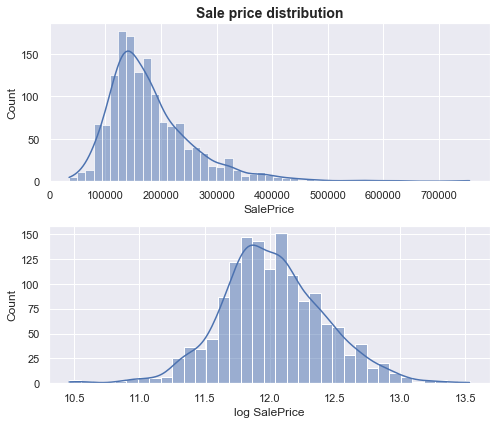

In [9]:
# SalePrice distribution
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    # sharex=True,
    figsize=(7, 3*2)
)

sns.histplot(
    data=train_df,
    x='SalePrice',
    kde=True,
    ax=axes[0]
)
sns.histplot(
    x=np.log1p(train_df['SalePrice']),
    kde=True,
    ax=axes[1] 
)

axes[0].set_title('Sale price distribution', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_xlabel('log SalePrice')
plt.tight_layout()
plt.show()

In [10]:
# log transform SalePrice
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

## Remove outliers (GrLivArea > 4000)

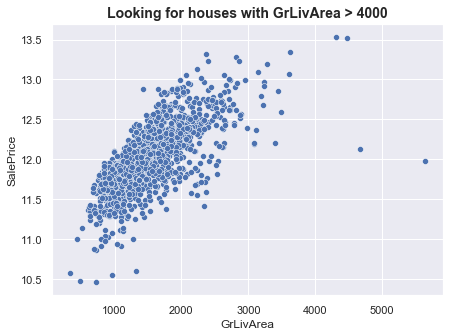

In [11]:
# look for outliers (GrLivArea > 4000)
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(
    data=train_df,
    x='GrLivArea', y='SalePrice'
)

ax.set_title('Looking for houses with GrLivArea > 4000', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

The author of the dataset recommends removing any house with more than 4000 squared feet

In [12]:
# remove outliers
to_drop_idx = train_df.loc[train_df['GrLivArea'] > 4000].index.values
print('remove {} outliers: {}'.format(len(to_drop_idx), to_drop_idx))

train_df.drop(index=to_drop_idx, inplace=True)

remove 4 outliers: [ 523  691 1182 1298]


## Handle missing values

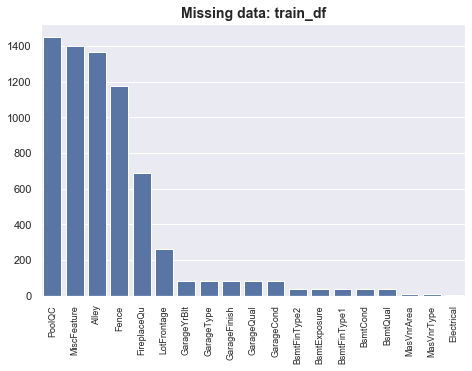

In [13]:
# check missing values: train_df
missing_df = train_df.isna().sum()
missing_df = missing_df.loc[missing_df > 0]
missing_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(len(missing_df)*0.4, 5))
ax = sns.barplot(
    x=missing_df.index,
    y=missing_df,
    color='b'
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
ax.set_title('Missing data: train_df', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

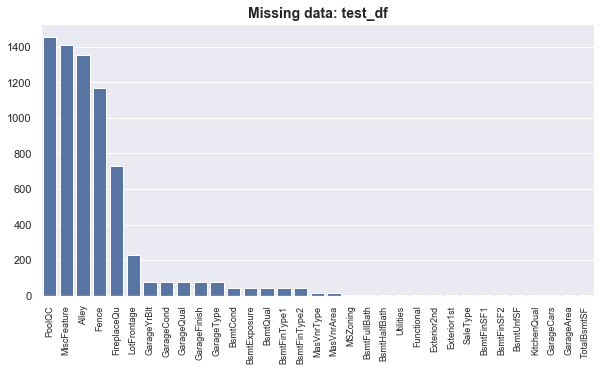

In [14]:
# check missing values: test_df
missing_df = test_df.isna().sum()
missing_df = missing_df.loc[missing_df > 0]
missing_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(len(missing_df)*0.3, 5))
ax = sns.barplot(
    x=missing_df.index,
    y=missing_df,
    color='b'
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
ax.set_title('Missing data: test_df', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [15]:
# handle missing values (manually)
def handle_missing_values(train_df, test_df):
    print('missing values before:')
    print('- train_df: {}'.format(train_df.isna().sum().sum()))
    print('- test_df: {}'.format(test_df.isna().sum().sum()))

    # MSZoning: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['MSZoning'] = imp.fit_transform(test_df[['MSZoning']])

    # LotFrontage: NA likely means 0
    train_df['LotFrontage'].fillna(0, inplace=True)
    test_df['LotFrontage'].fillna(0, inplace=True)

    # Alley: NA - no alley access
    train_df['Alley'].fillna('None', inplace=True)
    test_df['Alley'].fillna('None', inplace=True)

    # Utilities: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['Utilities'] = imp.fit_transform(test_df[['Utilities']])

    # Exterior1st: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['Exterior1st'] = imp.fit_transform(test_df[['Exterior1st']])

    # Exterior2nd: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['Exterior2nd'] = imp.fit_transform(test_df[['Exterior2nd']])

    # MasVnrType: NA likely means no masonry veneer
    train_df['MasVnrType'].fillna('None', inplace=True)
    test_df['MasVnrType'].fillna('None', inplace=True)

    # MasVnrArea: NA likely means 0
    train_df['MasVnrArea'].fillna(0, inplace=True)
    test_df['MasVnrArea'].fillna(0, inplace=True)

    # BsmtQual: NA - no basement
    train_df['BsmtQual'].fillna('None', inplace=True)
    test_df['BsmtQual'].fillna('None', inplace=True)

    # BsmtCond: NA - no basement
    train_df['BsmtCond'].fillna('None', inplace=True)
    test_df['BsmtCond'].fillna('None', inplace=True)

    # BsmtExposure: NA - no basement
    train_df['BsmtExposure'].fillna('None', inplace=True)
    test_df['BsmtExposure'].fillna('None', inplace=True)

    # BsmtFinType1: NA - no basement
    train_df['BsmtFinType1'].fillna('None', inplace=True)
    test_df['BsmtFinType1'].fillna('None', inplace=True)

    # BsmtFinSF1: NA likely means 0
    test_df['BsmtFinSF1'].fillna(0, inplace=True)

    # BsmtFinType2: NA - no basement
    train_df['BsmtFinType2'].fillna('None', inplace=True)
    test_df['BsmtFinType2'].fillna('None', inplace=True)

    # BsmtFinSF2: NA likely means 0
    test_df['BsmtFinSF2'].fillna(0, inplace=True)

    # BsmtUnfSF: NA likely means 0
    test_df['BsmtUnfSF'].fillna(0, inplace=True)

    # TotalBsmtSF: NA likely means 0
    test_df['TotalBsmtSF'].fillna(0, inplace=True)

    # Electrical: NA likely means standard
    train_df['Electrical'].fillna('SBrkr', inplace=True)
    test_df['Electrical'].fillna('SBrkr', inplace=True)

    # BsmtFullBath: NA likely means 0
    test_df['BsmtFullBath'].fillna(0, inplace=True)

    # BsmtHalfBath: NA likely means 0
    test_df['BsmtHalfBath'].fillna(0, inplace=True)

    # KitchenQual: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['KitchenQual'] = imp.fit_transform(test_df[['KitchenQual']])

    # Functional: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['Functional'] = imp.fit_transform(test_df[['Functional']])

    # FireplaceQu: NA - no fireplace
    train_df['FireplaceQu'].fillna('None', inplace=True)
    test_df['FireplaceQu'].fillna('None', inplace=True)

    # GarageType: NA - no garage
    train_df['GarageType'].fillna('None', inplace=True)
    test_df['GarageType'].fillna('None', inplace=True)

    # GarageYrBlt: NA - no garage
    train_df['GarageYrBlt'].fillna(0, inplace=True)
    test_df['GarageYrBlt'].fillna(0, inplace=True)

    # GarageFinish: NA - no garage
    train_df['GarageFinish'].fillna('None', inplace=True)
    test_df['GarageFinish'].fillna('None', inplace=True)

    # GarageCars: NA likely means 0
    test_df['GarageCars'].fillna(0, inplace=True)

    # GarageArea: NA likely means 0
    test_df['GarageArea'].fillna(0, inplace=True)

    # GarageQual: NA - no garage
    train_df['GarageQual'].fillna('None', inplace=True)
    test_df['GarageQual'].fillna('None', inplace=True)

    # GarageCond: NA - no garage
    train_df['GarageCond'].fillna('None', inplace=True)
    test_df['GarageCond'].fillna('None', inplace=True)

    # PoolQC: NA - no pool
    train_df['PoolQC'].fillna('None', inplace=True)
    test_df['PoolQC'].fillna('None', inplace=True)

    # Fence: NA - no fence
    train_df['Fence'].fillna('None', inplace=True)
    test_df['Fence'].fillna('None', inplace=True)

    # MiscFeature: NA - None
    train_df['MiscFeature'].fillna('None', inplace=True)
    test_df['MiscFeature'].fillna('None', inplace=True)

    # SaleType: fill NA with 'most_frequent'
    imp = SimpleImputer(strategy='most_frequent')
    test_df['SaleType'] = imp.fit_transform(test_df[['SaleType']])

    print('after:')
    print('- train_df: {}'.format(train_df.isna().sum().sum()))
    print('- test_df: {}'.format(test_df.isna().sum().sum()))

    return train_df, test_df

train_df, test_df = handle_missing_values(train_df, test_df)

missing values before:
- train_df: 6952
- test_df: 7000
after:
- train_df: 0
- test_df: 0


## Convert to categorical

Some numerical features are actually categorical

In [16]:
# MSSubClass, MoSold
def convert_to_categorical(df):
    df.replace({
        'MSSubClass': {
            20: 'SC20', 30: 'SC30', 40: 'SC40', 45: 'SC45', 50: 'SC50',
            60: 'SC60', 70: 'SC70', 75: 'SC75', 80: 'SC80', 85: 'SC85',
            90: 'SC90', 120: 'SC120', 150: 'SC150', 160: 'SC160', 180: 'SC180',
            190: 'SC190'
        },
        'MoSold': {
            1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
            6: 'Jun', 7: 'July', 8: 'Aug', 9:'Sep', 10: 'Oct',
            11: 'Nov', 12: 'Dec'
        }
    }, inplace=True)

    return df

train_df = convert_to_categorical(train_df)
test_df = convert_to_categorical(test_df)

# EDA
- features distribution
- features vs. SalePrice

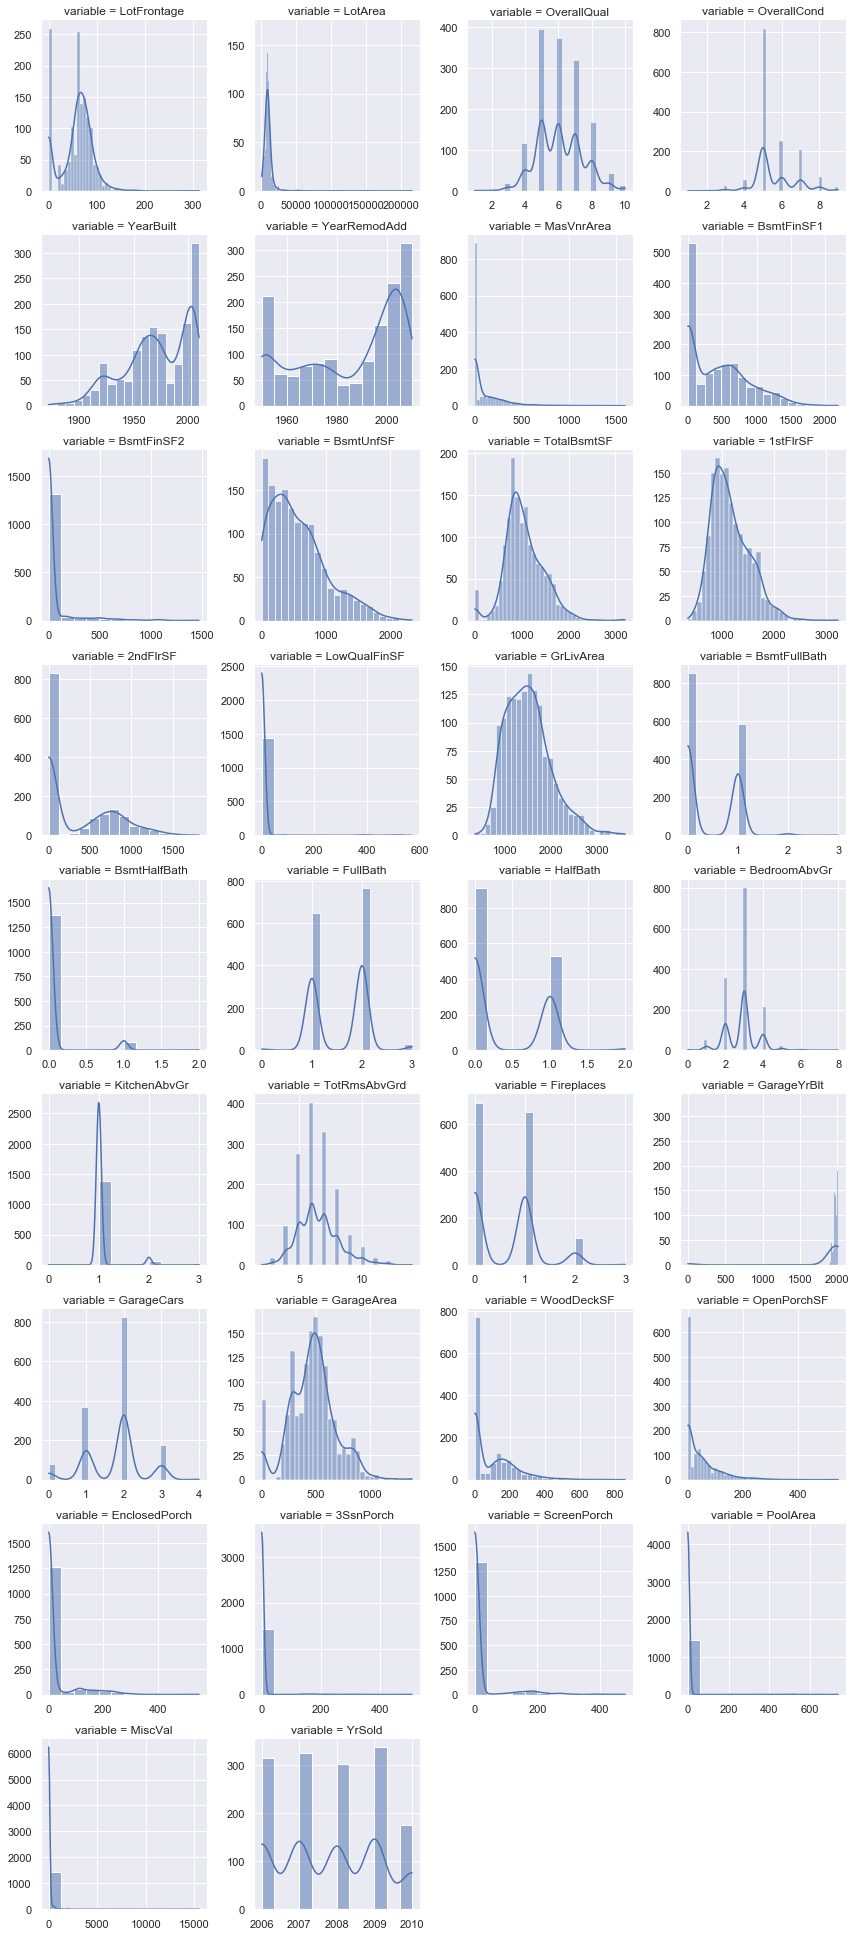

In [17]:
# numerical features: distribution
num_cols = train_df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['Id', 'SalePrice'])

train_melted_df = pd.melt(
    frame=train_df,
    id_vars='SalePrice', value_vars=num_cols
)

g = sns.FacetGrid(
    data=train_melted_df,
    col='variable', col_wrap=4,
    sharex=False, sharey=False
)
g = g.map_dataframe(sns.histplot, x='value', kde=True)

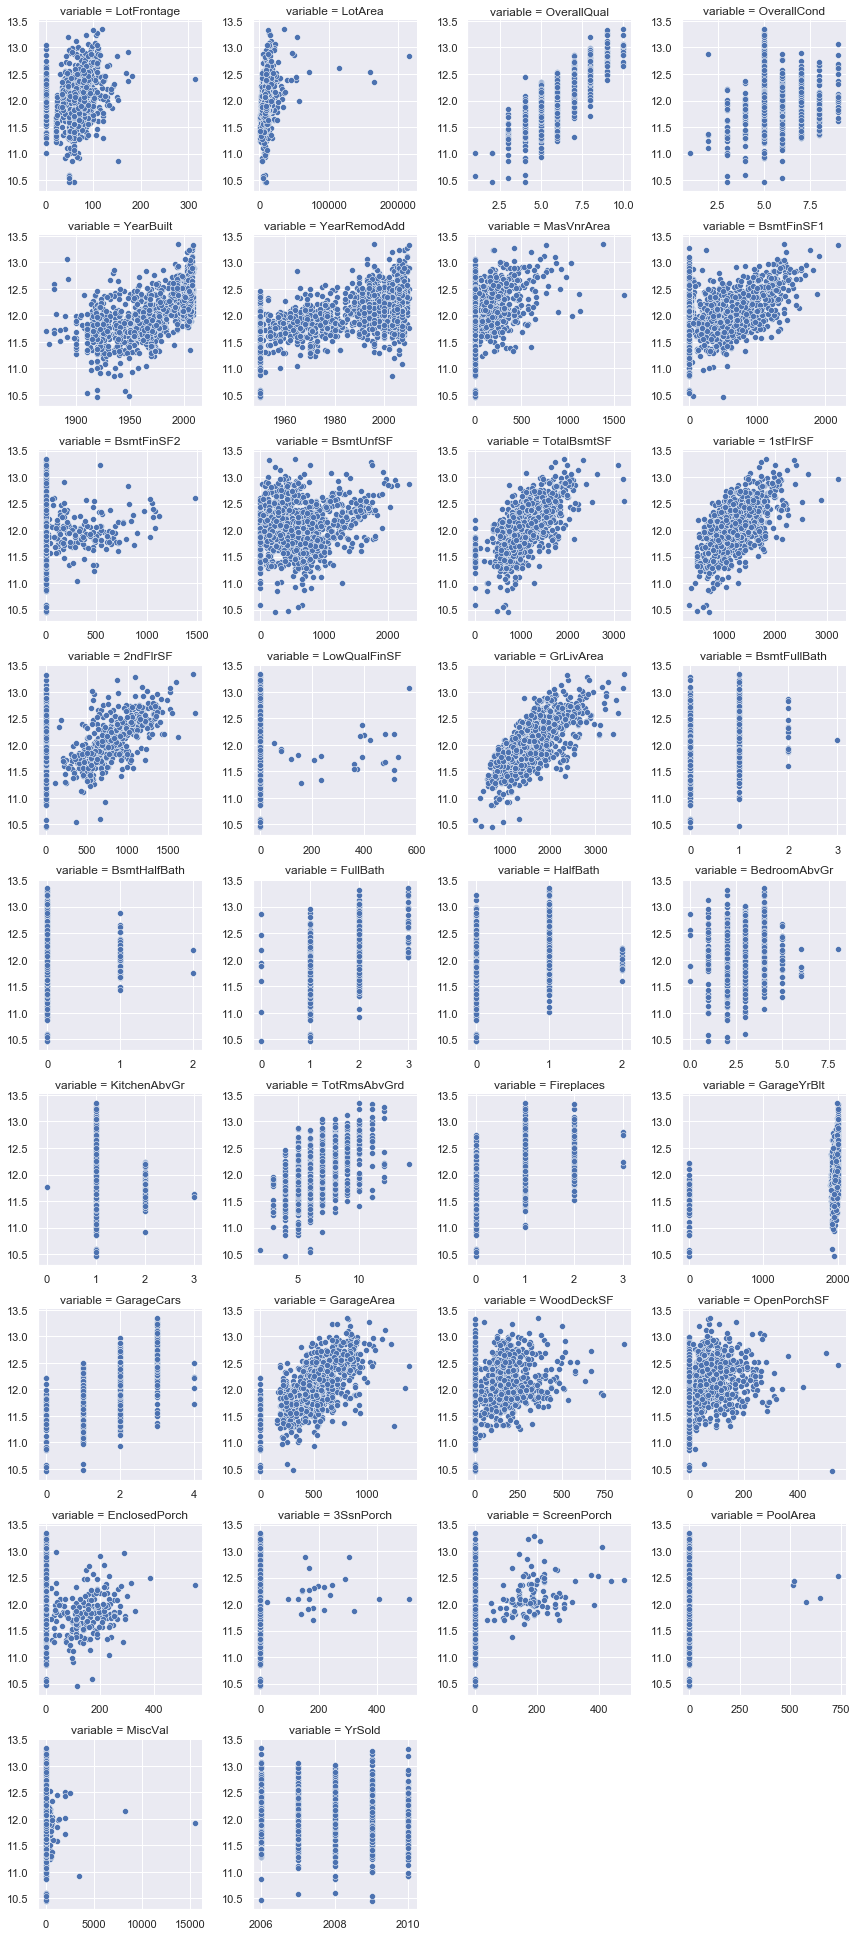

In [18]:
# numerical features vs. SalePrice
g = sns.FacetGrid(
    data=train_melted_df,
    col='variable', col_wrap=4,
    sharex=False, sharey=False
)
g = g.map_dataframe(sns.scatterplot, x='value', y='SalePrice')

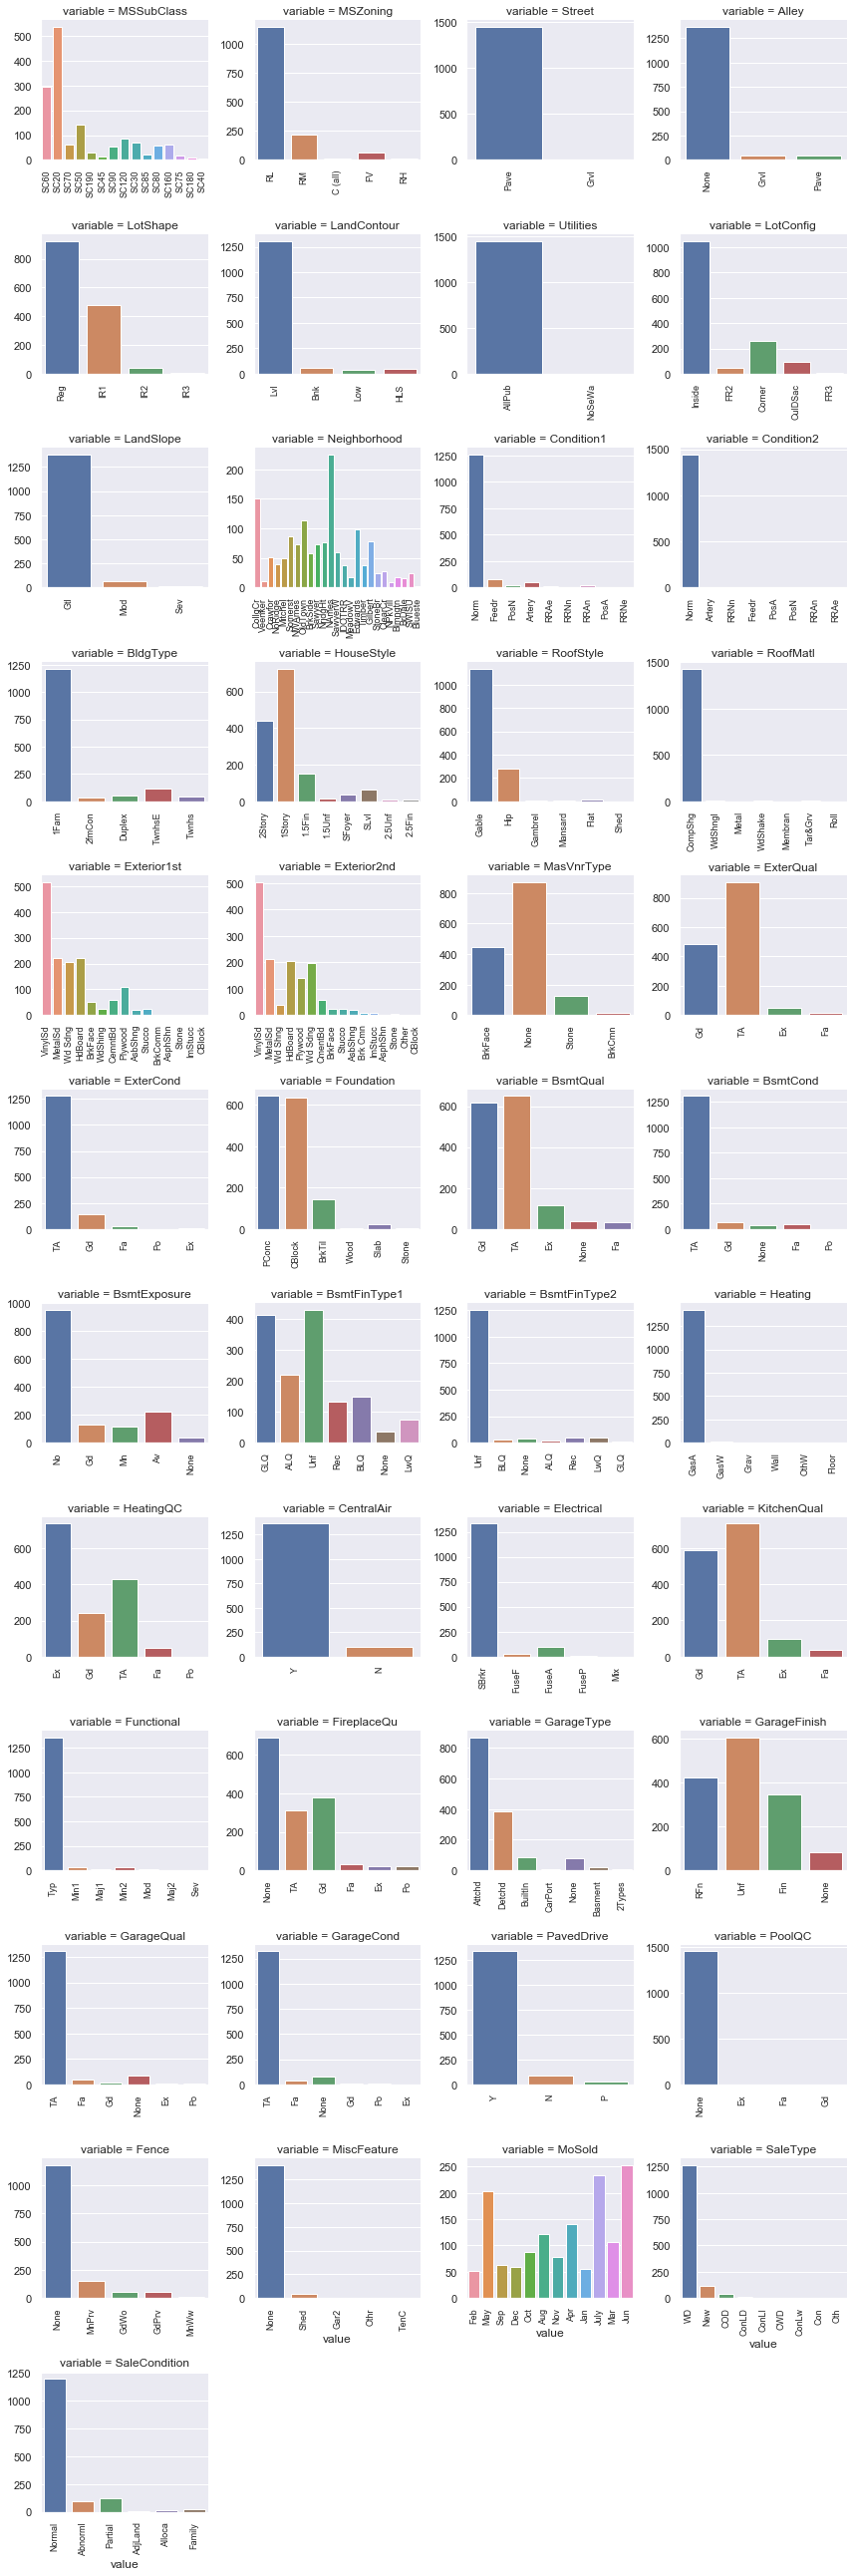

In [19]:
# categorical features: distribution
cat_cols = train_df.select_dtypes(include=object).columns

train_melted_df = pd.melt(
    frame=train_df,
    id_vars='SalePrice', value_vars=cat_cols
)

g = sns.FacetGrid(
    data=train_melted_df,
    col='variable', col_wrap=4,
    sharex=False, sharey=False
)
# g = g.map_dataframe(sns.countplot, x='value')

def countplot(x, y=None, **kwargs):
    sns.countplot(x=x)
    x = plt.xticks(rotation=90, fontsize=9)

g.map(countplot, 'value')
plt.show()

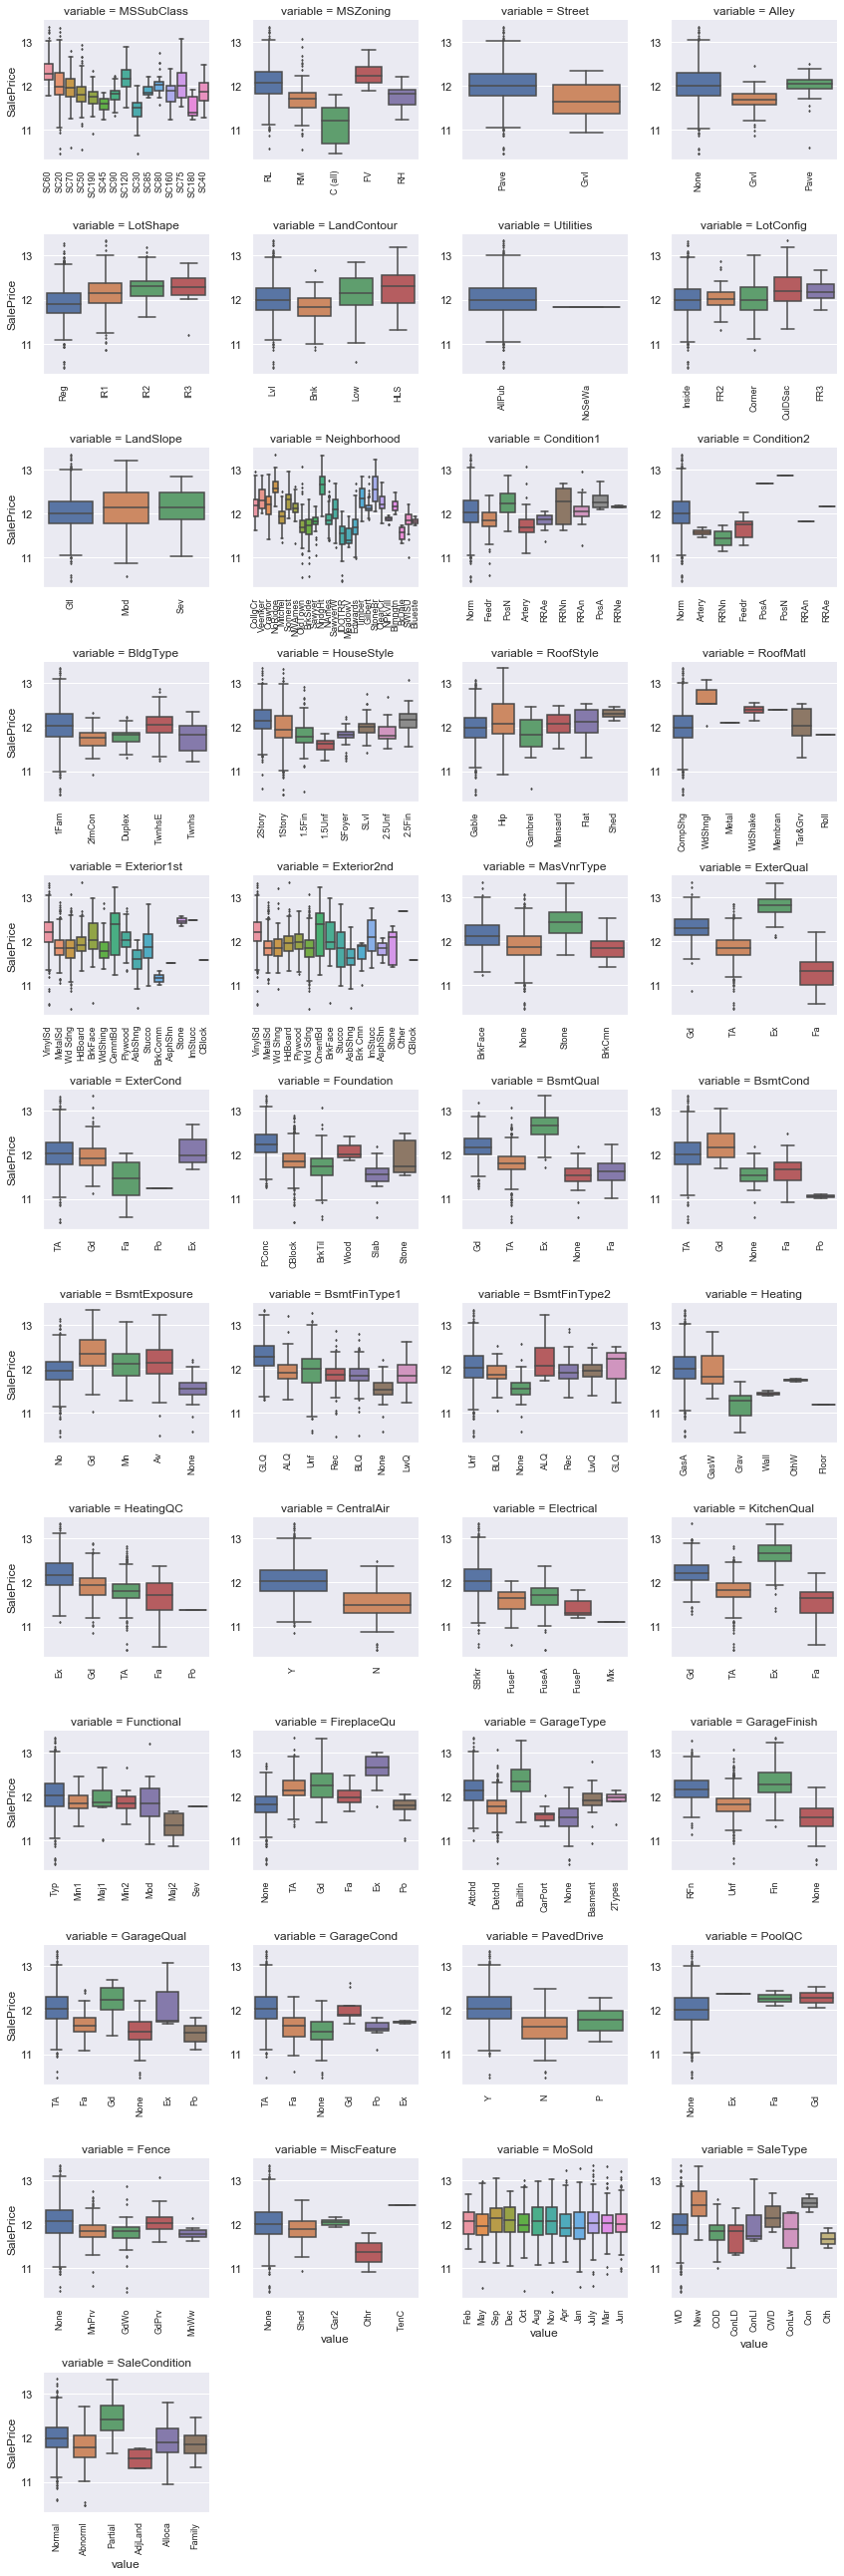

In [20]:
# categorical features vs. SalePrice
g = sns.FacetGrid(
    data=train_melted_df,
    col='variable', col_wrap=4,
    sharex=False, sharey=False
)
# g = g.map_dataframe(sns.boxplot, x='value', y='SalePrice')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y, fliersize=1.5)
    x = plt.xticks(rotation=90, fontsize=9)

g.map(boxplot, 'value', 'SalePrice')
plt.show()

# Feature engineering
- encode categorical features
- make boolean features
- make polinomials
- make combinations
- encode numerical features
- create X, y

## Encode categorical features

In [21]:
# onehot encode cat_features
def encode_cat_features(to_fit_df, to_transform_df, method=None):
    '''
    method: None or 'onehot'
    '''
    if method == 'onehot':
        enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc.fit(to_fit_df)
        cat_arr = enc.transform(to_transform_df)
        cat_df = pd.DataFrame(
            data=cat_arr,
            columns=enc.get_feature_names()
        )    
        
        return cat_df
    
    else:
        
        return to_transform_df

Encode some categorical features as ordered numbers as there is information in the order

In [22]:
# ordinal/mean encode cat_features
def encode_ordinal_features(to_fit_df, to_transform_df, cols, method='order'):
    '''
    method: 'order' or 'mean'
    '''
    for col in cols:
        ordering = pd.DataFrame()
        ordering['cat'] = to_fit_df[col].unique() # find unique categories in cat_col
        ordering.index = ordering['cat']
        ordering['mean'] = to_fit_df[[col, 'SalePrice']].groupby(col).agg('mean') # calculate SalePrice mean by categories
        ordering.sort_values('mean', inplace=True)
        ordering['ordering'] = np.arange(1, ordering.shape[0] + 1) # create orderings
        
        if method == 'mean':
            ordering = ordering['mean'].to_dict()
        else:
            ordering = ordering['ordering'].to_dict() # convert to dict

        for cat, value in ordering.items():
            to_transform_df.loc[to_transform_df[col] == cat, col + '_E'] = value
        
    # to_transform_df.drop(columns=cols, inplace=True)
    
    return to_transform_df

cols = train_df.select_dtypes(include='object').columns.values # cat_cols
print('encode {}/{} cat_features:'.format(len(cols), train_df.shape[1]))
print(cols)

train_df = encode_ordinal_features(train_df, train_df, cols, method='order')
test_df = encode_ordinal_features(train_df, test_df, cols, method='order')

train_df.drop(columns=cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

encode 45/81 cat_features:
['MSSubClass' 'MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour'
 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1'
 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'MoSold'
 'SaleType' 'SaleCondition']


In [23]:
# fill na in test_df with 'most_frequent'
cols = test_df.isna().any(axis=0)
cols = cols.loc[cols == True].index.tolist()
print('there are {} missing values in {} columns'.format(test_df.isna().sum().sum(), len(cols)))

for col in cols:
    imp = SimpleImputer(strategy='most_frequent')
    test_df[col] = imp.fit_transform(test_df[[col]])

there are 1 missing values in 1 columns


## Make boolean features

In [24]:
# make boolean features
def make_booleans(df, cols, bln_cols):
    for col, bln_col in zip(cols, bln_cols):
        if col == 'YearBuilt':
            df[bln_col] = df[col].apply(lambda x: 1 if x > 2000 else 0)
        else:
            df[bln_col] = df[col].apply(lambda x: 1 if x > 0 else 0)
    
    return df

cols = [
    'TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF',
    'OpenPorchSF', 'PoolArea', 'YearBuilt'
]
bln_cols =[
    'HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
    'HasPorch', 'HasPool', 'IsNew'
]

train_df = make_booleans(train_df, cols, bln_cols)
test_df = make_booleans(test_df, cols, bln_cols)

## Make polinomial features


In [25]:
# make polinomials
def make_polinomials(df, cols):
    for col in cols:
        df[col + '_2'] = df.loc[:, col]**2
        df[col + '_3'] = df.loc[:, col]**3
        df[col + '_sq'] = np.sqrt(df.loc[:, col])
    
    return df

corr_df = train_df.corr()
cols = np.abs(corr_df['SalePrice']).sort_values(ascending=False)
cols = cols.loc[cols > 0.5]
cols = cols.drop('SalePrice').index.values
print('select {} num_features to make polinomials:'.format(len(cols)))
print(cols)

train_df = make_polinomials(train_df, cols)
test_df = make_polinomials(test_df, cols)

select 19 num_features to make polinomials:
['OverallQual' 'Neighborhood_E' 'GrLivArea' 'ExterQual_E' 'GarageCars'
 'KitchenQual_E' 'GarageArea' 'BsmtQual_E' 'TotalBsmtSF' '1stFlrSF'
 'GarageFinish_E' 'FullBath' 'YearBuilt' 'GarageType_E' 'YearRemodAdd'
 'MSSubClass_E' 'Foundation_E' 'FireplaceQu_E' 'TotRmsAbvGrd']


## Make interactions

In [26]:
def make_combinations(df):
    # overall material and finish of the house
    df['OverallScore'] = df['OverallQual']*df['OverallCond']
    # material on the exterior 
    df['ExterScore'] = df['ExterQual_E']*df['ExterCond_E']
    # basement
    df['BsmtScore'] = df['BsmtQual_E']*df['BsmtCond_E']
    # kitchen
    df['KitchenScore'] = df['KitchenAbvGr']*df['KitchenQual_E']
    # fireplace
    df['FireplaceScore'] = df['Fireplaces']*df['FireplaceQu_E']
    # garage
    df['GarageScore'] = df['GarageQual_E']*df['GarageCond_E']
    # pool
    df['PoolScore'] = df['PoolArea']*df['PoolQC_E']

    # total bathrooms
    df['TotalBath'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'] + df['FullBath'] + 0.5*df['HalfBath']
    # total SF for house (incl. basement)
    df['AllSf'] = df['GrLivArea'] + df['TotalBsmtSF']
    # total SF for 1st + 2nd floors
    df['AllFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    # total SF for porch
    df['AllPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    return df

train_df = make_combinations(train_df)
test_df = make_combinations(test_df)

## Encode numerical features

In [27]:
# log transform
def log_transform(df, cols):
    transformed_df = df.copy()
    for col in cols:
        transformed_df.loc[:, col] = np.log1p(transformed_df[col])

    return transformed_df

In [28]:
# normalize numerical features
def normalize_num_features(to_fit_df, to_transform_df, method=None):
    '''
    mothod = None (default), 'minmax' or 'standard'
    '''
    if method == None:
        
        return to_transform_df

    else:
        if method == 'minmax':
            scaler = MinMaxScaler()
        elif method == 'standard':
            scaler = StandardScaler() 
        scaler.fit(to_fit_df)
        num_arr = scaler.transform(to_transform_df)
        num_df = pd.DataFrame(
            data=num_arr,
            columns=num_features
        )
        
        return num_df

## Create X, y

In [29]:
# differentiate num cat features
def differentiate_num_cat_features(train_df):
    num_features = train_df.select_dtypes(exclude=['object']).columns
    num_features = num_features.drop(['Id', 'SalePrice']).values
    cat_features = train_df.select_dtypes(include=['object']).columns.values

    print('{} num_features:'.format(num_features.shape[0]))
    print(num_features)
    print('{} cat_features:'.format(cat_features.shape[0]))
    print(cat_features)

    return num_features, cat_features

num_features, cat_features = differentiate_num_cat_features(train_df)

155 num_features:
['LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars'
 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal' 'YrSold' 'MSSubClass_E' 'MSZoning_E'
 'Street_E' 'Alley_E' 'LotShape_E' 'LandContour_E' 'Utilities_E'
 'LotConfig_E' 'LandSlope_E' 'Neighborhood_E' 'Condition1_E'
 'Condition2_E' 'BldgType_E' 'HouseStyle_E' 'RoofStyle_E' 'RoofMatl_E'
 'Exterior1st_E' 'Exterior2nd_E' 'MasVnrType_E' 'ExterQual_E'
 'ExterCond_E' 'Foundation_E' 'BsmtQual_E' 'BsmtCond_E' 'BsmtExposure_E'
 'BsmtFinType1_E' 'BsmtFinType2_E' 'Heating_E' 'HeatingQC_E'
 'CentralAir_E' 'Electrical_E' 'KitchenQual_E' 'Functional_E'
 'FireplaceQu_E' 'GarageType_E' 'GarageFinish_E' '

In [30]:
# create X, y
def create_X_y(num_features, cat_features, target, train_df, test_df):
    features = np.concatenate((num_features, cat_features), axis=0)
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]

    print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
    print('X_test shape: {}'.format(X_test.shape))

    return features, X_train, y_train, X_test

features, X_train, y_train, X_test = create_X_y(num_features, cat_features, 'SalePrice', train_df, test_df)

X_train shape: (1456, 155), y_train shape: (1456,)
X_test shape: (1459, 155)


# Other functions

In [31]:
# split data
def split_data(X_train, y_train, test_size=0.25):
    X_train_model, X_dev_model, y_train_model, y_dev_model = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
    print('X_train shape: {}, y_train shape: {}'.format(X_train_model.shape, y_train_model.shape))
    print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_model.shape, y_dev_model.shape))

    return X_train_model, X_dev_model, y_train_model, y_dev_model

In [32]:
# cross validation mertric: rmse_cv
scorer = make_scorer(
    score_func=mean_squared_error,
    greater_is_better=False
)

# kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmse_cv(model, X, y_true):
    rmse = np.sqrt(-cross_val_score(
        estimator=model,
        X=X, y=y_true,
        scoring=scorer,
        cv=10
    ))

    print('rmse_cv: {}'.format(rmse.mean()))

# Residuals analysis: remove outliers

In [33]:
X_train_tmp = X_train.copy()
y_train_tmp = y_train.copy()

In [34]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_tmp[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_tmp = log_transform(X_train_tmp, cols)

113/155 skewed num_features to log transform


In [35]:
# preprocess
X_train_num = normalize_num_features(X_train_tmp[num_features], X_train_tmp[num_features], method='standard')
X_train_cat = encode_cat_features(X_train_tmp[cat_features], X_train_tmp[cat_features], method='onehot')
X_train_tmp = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
y_train_tmp.reset_index(drop=True, inplace=True)

print('X_train shape: {}, y_train shape: {}'.format(X_train_tmp.shape, y_train_tmp.shape))

X_train shape: (1456, 155), y_train shape: (1456,)


In [36]:
# CV1
alphas = np.logspace(-4, 0, 5)
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_tmp, y_train_tmp)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 0.0001


In [37]:
# CV2
alphas = alpha * np.array([0.25, 0.5, 1, 2, 4, 8])
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_tmp, y_train_tmp)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 0.0004


In [38]:
%%time
# evaluate
print('on train:')
rmse_cv(lasso, X_train_tmp, y_train_tmp)

on train:
rmse_cv: 0.11238545125936031
Wall time: 1min 6s


In [39]:
# fit y_train on predictions => calculate residuals
regression = ols(
    formula='data ~ x',
    data=dict(data=y_train_tmp, x=lasso.predict(X_train_tmp))
).fit()

distance, p_value = OLSInfluence(regression).cooks_distance

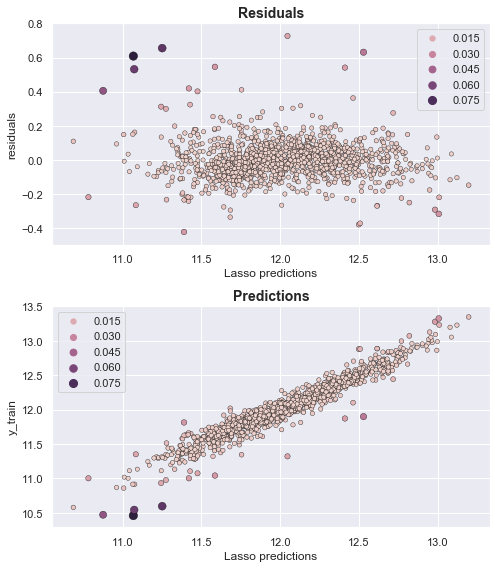

In [40]:
# plot residuals, predictions
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    figsize=(7, 4*2)
)

sns.scatterplot(
    x=lasso.predict(X_train_tmp),
    y=lasso.predict(X_train_tmp) - y_train_tmp,
    hue=distance, size=distance, 
    edgecolor='black',
    ax=axes[0]
)
axes[1] = sns.scatterplot(
    x=lasso.predict(X_train_tmp),
    y=y_train_tmp,
    hue=distance, size=distance, 
    edgecolor='black',
    ax=axes[1]
)

axes[0].set_xlabel('Lasso predictions')
axes[0].set_ylabel('residuals')
axes[0].set_title('Residuals', fontdict={'fontsize': 14, 'fontweight': 'bold'})
axes[1].set_xlabel('Lasso predictions')
axes[1].set_ylabel('y_train')
axes[1].set_title('Predictions', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

In [41]:
# find outliers
cooks_distance_df = pd.DataFrame()
cooks_distance_df['distance'] = distance
cooks_distance_df['p_value'] = p_value
cooks_distance_df.index = distance.index
cooks_distance_df

# to_drop_idx = [i for i, p in enumerate(p_value) if p < 0.96]
to_drop_idx = cooks_distance_df.loc[cooks_distance_df['distance'] > 0.017].index.values

print('found {} outliers:'.format(len(to_drop_idx)))
print(to_drop_idx)

found 12 outliers:
[  30  410  462  495  587  635  801  896  914  966  968 1320]


In [42]:
# remove outliers
X_train.drop(index=to_drop_idx, inplace=True)
y_train.drop(index=to_drop_idx, inplace=True)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

C:\Users\linhn\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)

In [44]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')['SalePrice']

# Linear models

## Preprocess 

In [45]:
# split data
X_test_linear = X_test.copy()
X_train_linear, X_dev_linear, y_train_linear, y_dev_linear = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


In [46]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_linear[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_linear = log_transform(X_train_linear, cols)
X_dev_linear = log_transform(X_dev_linear, cols)
X_test_linear = log_transform(X_test_linear, cols)

110/155 skewed num_features to log transform


In [47]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_linear[num_features], X_train_linear[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_linear[num_features], X_dev_linear[num_features], method='standard')
X_test_num = normalize_num_features(X_train_linear[num_features], X_test_linear[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [48]:
# preprocess cat_features (this does not need to perform after splitting train, dev sets)
X_train_cat = encode_cat_features(X_train[cat_features], X_train_linear[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_linear[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_linear[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [49]:
# concatenate
X_train_linear = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_linear = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_linear = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_linear.shape, y_train_linear.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_linear.shape, y_dev_linear.shape))
print('X_test shape: {}'.format(X_test_linear.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## Linear regression

In [50]:
# linear regression
linreg = LinearRegression()
linreg.fit(X_train_linear, y_train_linear)

LinearRegression()

In [51]:
%%time
# evaluate
print('on train:')
rmse_cv(linreg, X_train_linear, y_train_linear)

print('on dev:')
rmse_cv(linreg, X_dev_linear, y_dev_linear)

on train:
rmse_cv: 4164691719.1843195
on dev:
rmse_cv: 113845276163.55197
Wall time: 753 ms


## Ridge

In [52]:
# CV1
alphas = np.logspace(-5, 5, 11)
ridge = RidgeCV(alphas=alphas, cv=10, scoring='neg_root_mean_squared_error')
ridge.fit(X_train_linear, y_train_linear)

alpha = ridge.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 10.0


In [53]:
# CV2
alphas = alpha * np.array([0.25, 0.5, 1, 2, 4, 8])
ridge = RidgeCV(alphas=alphas, cv=10, scoring='neg_root_mean_squared_error')
ridge.fit(X_train_linear, y_train_linear)

alpha = ridge.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 10.0


In [54]:
%%time
# evaluate
print('on train:')
rmse_cv(ridge, X_train_linear, y_train_linear)

print('on dev:')
rmse_cv(ridge, X_dev_linear, y_dev_linear)

on train:
rmse_cv: 0.10427607607549465
on dev:
rmse_cv: 0.1187801134624854
Wall time: 12.8 s


In [55]:
# predict
y_pred_dev_ridge = ridge.predict(X_dev_linear)
y_pred_ridge = ridge.predict(X_test_linear)

### Features selection

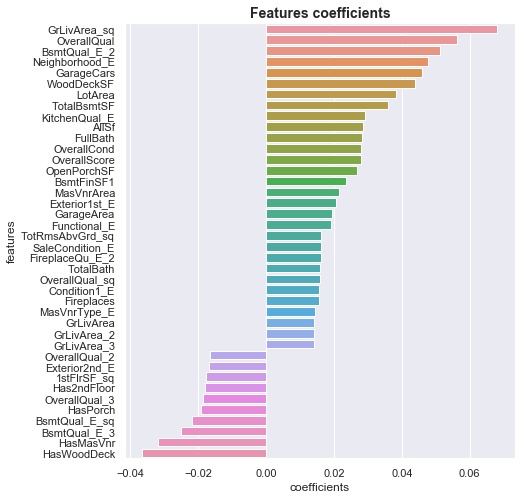

In [56]:
# features coefficients
importance_df = pd.DataFrame()
importance_df['features'] = X_train_linear.columns
importance_df['coefficients'] = ridge.coef_
importance_df.sort_values('coefficients', ascending=False, inplace=True)
tmp_df = pd.concat([importance_df.iloc[:30, :], importance_df.iloc[-10:, :]], axis=0)

plt.figure(figsize=(7, 0.2*len(tmp_df.index)))
ax = sns.barplot(
    data=tmp_df,
    x='coefficients',
    y='features',
    # color='b'
)

ax.set_title('Features coefficients', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [57]:
# select features
to_drop_cols = importance_df.loc[np.abs(importance_df['coefficients']) < 1e-3]['features'].tolist()
print('removes {}/{} features'.format(len(to_drop_cols), X_train_linear.shape[1]))

removes 13/155 features


In [58]:
# re-train CV1
alphas = np.logspace(-5, 5, 11)
ridge = RidgeCV(alphas=alphas, cv=10, scoring='neg_root_mean_squared_error')
ridge.fit(X_train_linear.drop(columns=to_drop_cols), y_train_linear)

alpha = ridge.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 10.0


In [59]:
# re-train CV2
alphas = alpha * np.array([0.25, 0.5, 1, 2, 4, 8])
ridge = RidgeCV(alphas=alphas, cv=10, scoring='neg_root_mean_squared_error')
ridge.fit(X_train_linear.drop(columns=to_drop_cols), y_train_linear)

alpha = ridge.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 10.0


In [60]:
%%time
# re-evaluate
print('on train:')
rmse_cv(ridge, X_train_linear.drop(columns=to_drop_cols), y_train_linear)

print('on dev:')
rmse_cv(ridge, X_dev_linear.drop(columns=to_drop_cols), y_dev_linear)

on train:
rmse_cv: 0.10333499737271908
on dev:
rmse_cv: 0.11711141856092148
Wall time: 11.5 s


In [61]:
# re-predict
y_pred_dev_ridge = ridge.predict(X_dev_linear.drop(columns=to_drop_cols))
y_pred_ridge = ridge.predict(X_test_linear.drop(columns=to_drop_cols))

## Lasso

In [62]:
# CV1
alphas = np.logspace(-4, 0, 5)
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_linear, y_train_linear)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 0.001


In [63]:
# CV2
alphas = alpha * np.array([0.25, 0.5, 1, 2, 4, 8])
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_linear, y_train_linear)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 0.0005


In [64]:
%%time
# evaluate
print('on train:')
rmse_cv(lasso, X_train_linear, y_train_linear)

print('on dev:')
rmse_cv(lasso, X_dev_linear, y_dev_linear)

on train:
rmse_cv: 0.10467939590507054
on dev:
rmse_cv: 0.11740130848411871
Wall time: 14.3 s


In [65]:
# predict
y_pred_dev_lasso = lasso.predict(X_dev_linear)
y_pred_lasso = lasso.predict(X_test_linear)

### Features selection

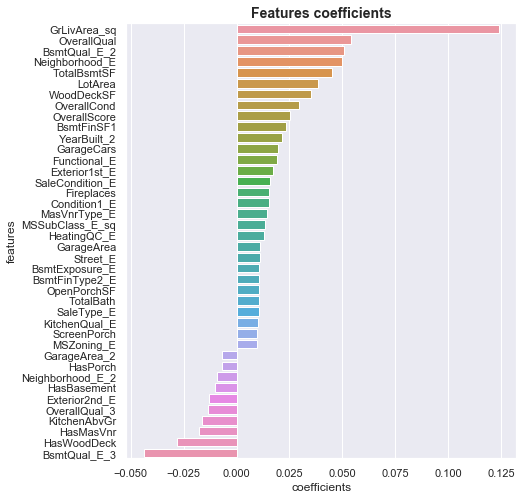

In [66]:
# features coefficients
importance_df = pd.DataFrame()
importance_df['features'] = X_train_linear.columns
importance_df['coefficients'] = lasso.coef_
importance_df.sort_values('coefficients', ascending=False, inplace=True)
tmp_df = pd.concat([importance_df.iloc[:30, :], importance_df.iloc[-10:, :]], axis=0)

plt.figure(figsize=(7, 0.2*len(tmp_df.index)))
ax = sns.barplot(
    data=tmp_df,
    x='coefficients',
    y='features',
    # color='b'
)

ax.set_title('Features coefficients', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [67]:
# select features
to_drop_cols = importance_df.loc[np.abs(importance_df['coefficients']) < 1e-3]['features'].tolist()
print('lasso removes {}/{} features'.format(len(to_drop_cols), X_train_linear.shape[1]))

lasso removes 81/155 features


In [68]:
# re-train CV1
alphas = np.logspace(-4, 0, 5)
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_linear.drop(columns=to_drop_cols), y_train_linear)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 0.0001


In [69]:
# re-train CV2
alphas = alpha * np.array([0.5, 1, 2, 4, 8])
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10)
lasso.fit(X_train_linear.drop(columns=to_drop_cols), y_train_linear)

alpha = lasso.alpha_
print('best alpha: {}'.format(alpha))

best alpha: 5e-05


In [70]:
%%time
# re-evaluate
print('on train:')
rmse_cv(lasso, X_train_linear.drop(columns=to_drop_cols), y_train_linear)

print('on dev:')
rmse_cv(lasso, X_dev_linear.drop(columns=to_drop_cols), y_dev_linear)

on train:
rmse_cv: 0.10145498753995348
on dev:
rmse_cv: 0.12232227068979892
Wall time: 5.17 s


In [71]:
# re-predict
y_pred_dev_lasso = lasso.predict(X_dev_linear.drop(columns=to_drop_cols))
y_pred_lasso = lasso.predict(X_test_linear.drop(columns=to_drop_cols))

# SVM

## Split data

In [72]:
# split data
X_test_svr = X_test.copy()
X_train_svr, X_dev_svr, y_train_svr, y_dev_svr = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


## Preprocess

In [73]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_svr[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_svr = log_transform(X_train_svr, cols)
X_dev_svr = log_transform(X_dev_svr, cols)
X_test_svr = log_transform(X_test_svr, cols)

110/155 skewed num_features to log transform


In [74]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_svr[num_features], X_train_svr[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_svr[num_features], X_dev_svr[num_features], method='standard')
X_test_num = normalize_num_features(X_train_svr[num_features], X_test_svr[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [75]:
# preprocess cat_features
X_train_cat = encode_cat_features(X_train[cat_features], X_train_svr[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_svr[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_svr[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [76]:
# concatenate
X_train_svr = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_svr = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_svr = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_svr.shape, y_train_svr.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_svr.shape, y_dev_svr.shape))
print('X_test shape: {}'.format(X_test_svr.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## SVR

In [77]:
# preliminary model
svr = SVR()
svr.fit(X_train_svr, y_train_svr)

SVR()

In [78]:
%%time
# evaluate
print('on train:')
rmse_cv(svr, X_train_svr, y_train_svr)

print('on dev:')
rmse_cv(svr, X_dev_svr, y_dev_svr)

on train:
rmse_cv: 0.1372437060746549
on dev:
rmse_cv: 0.18991589438684003
Wall time: 1.17 s


In [79]:
# CV 1
param_grid = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.001, 0.01, 0.1, 1, 10],
}

optimal_params = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    # verbose=0
)

optimal_params.fit(
    X=X_train_svr,
    y=y_train_svr
)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error')

In [80]:
print('best params: {}'.format(optimal_params.best_params_))

best params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


In [81]:
# CV 2
param_grid = {
    'kernel': ['rbf'],
    'C': 1 * np.array([0.25, 0.5, 1, 2, 4, 8]),
    'gamma': 0.001 * np.array([0.25, 0.5, 1, 2, 4, 8]),
}

optimal_params = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    # verbose=0
)

optimal_params.fit(
    X=X_train_svr,
    y=y_train_svr
)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([0.25, 0.5 , 1.  , 2.  , 4.  , 8.  ]),
                         'gamma': array([0.00025, 0.0005 , 0.001  , 0.002  , 0.004  , 0.008  ]),
                         'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error')

In [82]:
print('best params: {}'.format(optimal_params.best_params_))

best params: {'C': 8.0, 'gamma': 0.00025, 'kernel': 'rbf'}


In [83]:
# svr
svr = SVR(
    kernel='rbf',
    gamma=0.00025,
    C=8
)
svr.fit(X_train_svr, y_train_svr)

SVR(C=8, gamma=0.00025)

In [84]:
%%time
# evaluate
print('on train:')
rmse_cv(svr, X_train_svr, y_train_svr)

print('on dev:')
rmse_cv(svr, X_dev_svr, y_dev_svr)

on train:
rmse_cv: 0.10586148582650243
on dev:
rmse_cv: 0.12485807297936555
Wall time: 1.15 s


In [86]:
# predict
y_pred_dev_svr = svr.predict(X_dev_svr)
y_pred_svr = svr.predict(X_test_svr)

# Random forest

## Split data

In [87]:
# split data
X_test_forest = X_test.copy()
X_train_forest, X_dev_forest, y_train_forest, y_dev_forest = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


## Preprocess

In [88]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_forest[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_forest = log_transform(X_train_forest, cols)
X_dev_forest = log_transform(X_dev_forest, cols)
X_test_forest = log_transform(X_test_forest, cols)

110/155 skewed num_features to log transform


In [89]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_forest[num_features], X_train_forest[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_forest[num_features], X_dev_forest[num_features], method='standard')
X_test_num = normalize_num_features(X_train_forest[num_features], X_test_forest[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [90]:
# preprocess cat_features
X_train_cat = encode_cat_features(X_train[cat_features], X_train_forest[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_forest[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_forest[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [91]:
# concatenate
X_train_forest = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_forest = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_forest = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_forest.shape, y_train_forest.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_forest.shape, y_dev_forest.shape))
print('X_test shape: {}'.format(X_test_forest.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## Random forest

In [92]:
# preliminary model
forest = RandomForestRegressor(n_estimators=150, max_features=0.5, oob_score=True)
forest.fit(X_train_forest, y_train_forest)

RandomForestRegressor(max_features=0.5, n_estimators=150, oob_score=True)

In [93]:
print('oob score: {}'.format(forest.oob_score_))

oob score: 0.8946446939850301


In [94]:
%%time
# evaluate
print('on train:')
rmse_cv(forest, X_train_forest, y_train_forest)

print('on dev:')
rmse_cv(forest, X_dev_forest, y_dev_forest)

on train:
rmse_cv: 0.12419022192295885
on dev:
rmse_cv: 0.14215435627782005
Wall time: 30.3 s


In [95]:
# grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9, 11],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
}

optimal_params = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    # verbose=0
)

optimal_params.fit(
    X=X_train_forest,
    y=y_train_forest
)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9, 11],
                         'max_features': ['sqrt', 'log2', 0.5, 0.7],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [96]:
print('best params: {}'.format(optimal_params.best_params_))

best params: {'max_depth': 9, 'max_features': 0.7, 'n_estimators': 200}


In [100]:
# random forest
forest = RandomForestRegressor(
    n_estimators=200,
    max_depth=9,
    max_features=0.7,
    oob_score=True)

forest.fit(X_train_forest, y_train_forest)

RandomForestRegressor(max_depth=9, max_features=0.7, n_estimators=200,
                      oob_score=True)

In [101]:
print('oob score: {}'.format(forest.oob_score_))

oob score: 0.8955418457825732


In [102]:
%%time
# evaluate
print('on train:')
rmse_cv(forest, X_train_forest, y_train_forest)

print('on dev:')
rmse_cv(forest, X_dev_forest, y_dev_forest)

on train:
rmse_cv: 0.12576406653060757
on dev:
rmse_cv: 0.14208546798993327
Wall time: 44 s


In [103]:
# predict
y_pred_dev_forest = forest.predict(X_dev_forest)
y_pred_forest = forest.predict(X_test_forest)

# Xgboost

## Split data

In [104]:
# split data
X_test_xgb = X_test.copy()
X_train_xgb, X_dev_xgb, y_train_xgb, y_dev_xgb = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


## Preprocess

In [105]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_xgb[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_xgb = log_transform(X_train_xgb, cols)
X_dev_xgb = log_transform(X_dev_xgb, cols)
X_test_xgb = log_transform(X_test_xgb, cols)

110/155 skewed num_features to log transform


In [106]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_xgb[num_features], X_train_xgb[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_xgb[num_features], X_dev_xgb[num_features], method='standard')
X_test_num = normalize_num_features(X_train_xgb[num_features], X_test_xgb[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [107]:
# preprocess cat_features
X_train_cat = encode_cat_features(X_train[cat_features], X_train_xgb[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_xgb[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_xgb[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [108]:
# concatenate
X_train_xgb = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_xgb = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_xgb = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_xgb.shape, y_train_xgb.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_xgb.shape, y_dev_xgb.shape))
print('X_test shape: {}'.format(X_test_xgb.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## Xgboost model

In [109]:
# preliminary model
reg_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror',
    # subsample=0.8, # data
    # colsample_bytree=0.5, # features
    # colsample_bylevel=0.5, # features
    random_state=42
)

reg_xgb.fit(
    X=X_train_xgb,
    y=y_train_xgb,
    eval_set=[(X_dev_xgb, y_dev_xgb)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[0]	validation_0-rmse:8.08349
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.66188
[2]	validation_0-rmse:3.97222
[3]	validation_0-rmse:2.78549
[4]	validation_0-rmse:1.95800
[5]	validation_0-rmse:1.37756
[6]	validation_0-rmse:0.97578
[7]	validation_0-rmse:0.69685
[8]	validation_0-rmse:0.50127
[9]	validation_0-rmse:0.36929
[10]	validation_0-rmse:0.27961
[11]	validation_0-rmse:0.22088
[12]	validation_0-rmse:0.18381
[13]	validation_0-rmse:0.16034
[14]	validation_0-rmse:0.14824
[15]	validation_0-rmse:0.14078
[16]	validation_0-rmse:0.13751
[17]	validation_0-rmse:0.13513
[18]	validation_0-rmse:0.13335
[19]	validation_0-rmse:0.13194
[20]	validation_0-rmse:0.13101
[21]	validation_0-rmse:0.13036
[22]	validation_0-rmse:0.13005
[23]	validation_0-rmse:0.13007
[24]	validation_0-rmse:0.12946
[25]	validation_0-rmse:0.12986
[26]	validation_0-rmse:0.12956
[27]	validation_0-rmse:0.12970
[28]	validation_0-rmse:0.12933
[29]	validation_0-rmse:0.12943
[30]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
%%time
# CV 1
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0, 0.5, 1],
    'reg_lambda': [0, 1, 10]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=1000,
        objective='reg:squarederror',
        # subsample=0.8,
        # colsample_bytree=0.5,
        # colsample_bylevel=0.5,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    # verbose=0
)

optimal_params.fit(
    X=X_train_xgb,
    y=y_train_xgb,
    eval_set=[(X_dev_xgb, y_dev_xgb)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=False
)

In [ ]:
print('best params: {}'.format(optimal_params.best_params_))

In [ ]:
%%time
# CV 2
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.5],
    'reg_lambda': [0, 1, 10]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBRegressor(
        n_estimators=1000,
        objective='reg:squarederror',
        # subsample=0.8,
        # colsample_bytree=0.5,
        # colsample_bylevel=0.5,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    # verbose=0
)

optimal_params.fit(
    X=X_train_xgb,
    y=y_train_xgb,
    eval_set=[(X_dev_xgb, y_dev_xgb)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=False
)

In [ ]:
print('best params: {}'.format(optimal_params.best_params_))

In [110]:
# xgboost model
reg_xgb = xgb.XGBRegressor(
    n_estimators=5000,
    objective='reg:squarederror',
    learning_rate=0.05,
    gamma=0,
    max_depth=3,
    # subsample=0.8,
    # colsample_bytree=0.5,
    # colsample_bylevel=0.5,
    reg_lambda=1,
    random_state=42
)

reg_xgb.fit(
    X=X_train_xgb,
    y=y_train_xgb,
    eval_set=[(X_dev_xgb, y_dev_xgb)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[0]	validation_0-rmse:10.95997
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.41330
[2]	validation_0-rmse:9.89399
[3]	validation_0-rmse:9.40065
[4]	validation_0-rmse:8.93200
[5]	validation_0-rmse:8.48680
[6]	validation_0-rmse:8.06296
[7]	validation_0-rmse:7.66157
[8]	validation_0-rmse:7.27898
[9]	validation_0-rmse:6.91570
[10]	validation_0-rmse:6.57156
[11]	validation_0-rmse:6.24347
[12]	validation_0-rmse:5.93284
[13]	validation_0-rmse:5.63686
[14]	validation_0-rmse:5.35645
[15]	validation_0-rmse:5.08962
[16]	validation_0-rmse:4.83581
[17]	validation_0-rmse:4.59540
[18]	validation_0-rmse:4.36615
[19]	validation_0-rmse:4.14896
[20]	validation_0-rmse:3.94254
[21]	validation_0-rmse:3.74643
[22]	validation_0-rmse:3.56043
[23]	validation_0-rmse:3.38312
[24]	validation_0-rmse:3.21498
[25]	validation_0-rmse:3.05585
[26]	validation_0-rmse:2.90467
[27]	validation_0-rmse:2.76085
[28]	validation_0-rmse:2.62405
[29]	validation_0-rmse:2.49394
[30]	validat

[258]	validation_0-rmse:0.11919
[259]	validation_0-rmse:0.11915
[260]	validation_0-rmse:0.11914
[261]	validation_0-rmse:0.11916
[262]	validation_0-rmse:0.11911
[263]	validation_0-rmse:0.11909
[264]	validation_0-rmse:0.11909
[265]	validation_0-rmse:0.11912
[266]	validation_0-rmse:0.11907
[267]	validation_0-rmse:0.11908
[268]	validation_0-rmse:0.11908
[269]	validation_0-rmse:0.11905
[270]	validation_0-rmse:0.11895
[271]	validation_0-rmse:0.11895
[272]	validation_0-rmse:0.11891
[273]	validation_0-rmse:0.11888
[274]	validation_0-rmse:0.11887
[275]	validation_0-rmse:0.11885
[276]	validation_0-rmse:0.11882
[277]	validation_0-rmse:0.11874
[278]	validation_0-rmse:0.11872
[279]	validation_0-rmse:0.11873
[280]	validation_0-rmse:0.11869
[281]	validation_0-rmse:0.11870
[282]	validation_0-rmse:0.11863
[283]	validation_0-rmse:0.11865
[284]	validation_0-rmse:0.11858
[285]	validation_0-rmse:0.11858
[286]	validation_0-rmse:0.11856
[287]	validation_0-rmse:0.11850
[288]	validation_0-rmse:0.11845
[289]	va

[515]	validation_0-rmse:0.11534
[516]	validation_0-rmse:0.11528
[517]	validation_0-rmse:0.11528
[518]	validation_0-rmse:0.11524
[519]	validation_0-rmse:0.11528
[520]	validation_0-rmse:0.11525
[521]	validation_0-rmse:0.11518
[522]	validation_0-rmse:0.11516
[523]	validation_0-rmse:0.11515
[524]	validation_0-rmse:0.11515
[525]	validation_0-rmse:0.11512
[526]	validation_0-rmse:0.11512
[527]	validation_0-rmse:0.11514
[528]	validation_0-rmse:0.11512
[529]	validation_0-rmse:0.11510
[530]	validation_0-rmse:0.11509
[531]	validation_0-rmse:0.11507
[532]	validation_0-rmse:0.11506
[533]	validation_0-rmse:0.11503
[534]	validation_0-rmse:0.11505
[535]	validation_0-rmse:0.11506
[536]	validation_0-rmse:0.11502
[537]	validation_0-rmse:0.11501
[538]	validation_0-rmse:0.11500
[539]	validation_0-rmse:0.11502
[540]	validation_0-rmse:0.11499
[541]	validation_0-rmse:0.11499
[542]	validation_0-rmse:0.11498
[543]	validation_0-rmse:0.11496
[544]	validation_0-rmse:0.11496
[545]	validation_0-rmse:0.11492
[546]	va

[772]	validation_0-rmse:0.11438
[773]	validation_0-rmse:0.11439
[774]	validation_0-rmse:0.11436
[775]	validation_0-rmse:0.11436
[776]	validation_0-rmse:0.11433
[777]	validation_0-rmse:0.11433
[778]	validation_0-rmse:0.11435
[779]	validation_0-rmse:0.11431
[780]	validation_0-rmse:0.11430
[781]	validation_0-rmse:0.11428
[782]	validation_0-rmse:0.11429
[783]	validation_0-rmse:0.11431
[784]	validation_0-rmse:0.11432
[785]	validation_0-rmse:0.11431
[786]	validation_0-rmse:0.11433
[787]	validation_0-rmse:0.11433
[788]	validation_0-rmse:0.11435
[789]	validation_0-rmse:0.11437
[790]	validation_0-rmse:0.11438
[791]	validation_0-rmse:0.11438
[792]	validation_0-rmse:0.11437
[793]	validation_0-rmse:0.11437
[794]	validation_0-rmse:0.11436
[795]	validation_0-rmse:0.11437
[796]	validation_0-rmse:0.11438
[797]	validation_0-rmse:0.11438
[798]	validation_0-rmse:0.11440
[799]	validation_0-rmse:0.11440
[800]	validation_0-rmse:0.11439
[801]	validation_0-rmse:0.11438
[802]	validation_0-rmse:0.11438
[803]	va

[1028]	validation_0-rmse:0.11396
[1029]	validation_0-rmse:0.11396
[1030]	validation_0-rmse:0.11395
[1031]	validation_0-rmse:0.11397
[1032]	validation_0-rmse:0.11395
[1033]	validation_0-rmse:0.11396
[1034]	validation_0-rmse:0.11396
[1035]	validation_0-rmse:0.11395
[1036]	validation_0-rmse:0.11394
[1037]	validation_0-rmse:0.11395
[1038]	validation_0-rmse:0.11396
[1039]	validation_0-rmse:0.11395
[1040]	validation_0-rmse:0.11395
[1041]	validation_0-rmse:0.11398
[1042]	validation_0-rmse:0.11398
[1043]	validation_0-rmse:0.11398
[1044]	validation_0-rmse:0.11397
[1045]	validation_0-rmse:0.11397
[1046]	validation_0-rmse:0.11398
[1047]	validation_0-rmse:0.11398
[1048]	validation_0-rmse:0.11398
[1049]	validation_0-rmse:0.11398
[1050]	validation_0-rmse:0.11396
[1051]	validation_0-rmse:0.11395
[1052]	validation_0-rmse:0.11395
[1053]	validation_0-rmse:0.11397
[1054]	validation_0-rmse:0.11398
[1055]	validation_0-rmse:0.11396
[1056]	validation_0-rmse:0.11396
[1057]	validation_0-rmse:0.11398
[1058]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
%%time
# evaluate
print('on train:')
rmse_cv(reg_xgb, X_train_xgb, y_train_xgb)

print('on dev:')
rmse_cv(reg_xgb, X_dev_xgb, y_dev_xgb)

on train:
rmse_cv: 0.10754666020406048
on dev:
rmse_cv: 0.12410105695744747
Wall time: 3min 29s


In [112]:
# predict
y_pred_dev_xgb = reg_xgb.predict(X_dev_xgb)
y_pred_xgb = reg_xgb.predict(X_test_xgb)

### Features selection

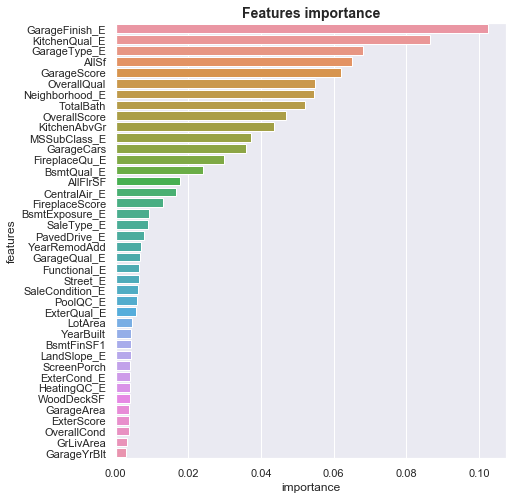

In [113]:
# features importance
importance_df = pd.DataFrame()
importance_df['features'] = X_train_xgb.columns
importance_df['importance'] = reg_xgb.feature_importances_
importance_df.sort_values('importance', ascending=False, inplace=True)
tmp_df = importance_df.iloc[:40, :]

plt.figure(figsize=(7, 0.2*len(tmp_df.index)))
ax = sns.barplot(
    data=tmp_df,
    x='importance',
    y='features',
)

ax.set_title('Features importance', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [114]:
# select features
to_drop_cols = importance_df.loc[importance_df['importance'] < 1e-4]['features'].tolist()
print('removes {}/{} features'.format(len(to_drop_cols), X_train_xgb.shape[1]))

removes 70/155 features


In [115]:
# re-train
reg_xgb = xgb.XGBRegressor(
    n_estimators=5000,
    objective='reg:squarederror',
    learning_rate=0.05,
    gamma=0,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    reg_lambda=1,
    random_state=42
)

reg_xgb.fit(
    X=X_train_xgb.drop(columns=to_drop_cols),
    y=y_train_xgb,
    eval_set=[(X_dev_xgb.drop(columns=to_drop_cols), y_dev_xgb)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[0]	validation_0-rmse:10.96046
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:10.41431
[2]	validation_0-rmse:9.89530
[3]	validation_0-rmse:9.40246
[4]	validation_0-rmse:8.93376
[5]	validation_0-rmse:8.48864
[6]	validation_0-rmse:8.06582
[7]	validation_0-rmse:7.66388
[8]	validation_0-rmse:7.28278
[9]	validation_0-rmse:6.92015
[10]	validation_0-rmse:6.57497
[11]	validation_0-rmse:6.24671
[12]	validation_0-rmse:5.93579
[13]	validation_0-rmse:5.63996
[14]	validation_0-rmse:5.35956
[15]	validation_0-rmse:5.09217
[16]	validation_0-rmse:4.83853
[17]	validation_0-rmse:4.59830
[18]	validation_0-rmse:4.36915
[19]	validation_0-rmse:4.15185
[20]	validation_0-rmse:3.94581
[21]	validation_0-rmse:3.74981
[22]	validation_0-rmse:3.56306
[23]	validation_0-rmse:3.38645
[24]	validation_0-rmse:3.21829
[25]	validation_0-rmse:3.05861
[26]	validation_0-rmse:2.90677
[27]	validation_0-rmse:2.76245
[28]	validation_0-rmse:2.62600
[29]	validation_0-rmse:2.49592
[30]	validat

[258]	validation_0-rmse:0.11898
[259]	validation_0-rmse:0.11884
[260]	validation_0-rmse:0.11880
[261]	validation_0-rmse:0.11873
[262]	validation_0-rmse:0.11864
[263]	validation_0-rmse:0.11865
[264]	validation_0-rmse:0.11865
[265]	validation_0-rmse:0.11858
[266]	validation_0-rmse:0.11855
[267]	validation_0-rmse:0.11851
[268]	validation_0-rmse:0.11861
[269]	validation_0-rmse:0.11864
[270]	validation_0-rmse:0.11864
[271]	validation_0-rmse:0.11875
[272]	validation_0-rmse:0.11872
[273]	validation_0-rmse:0.11859
[274]	validation_0-rmse:0.11855
[275]	validation_0-rmse:0.11853
[276]	validation_0-rmse:0.11845
[277]	validation_0-rmse:0.11844
[278]	validation_0-rmse:0.11845
[279]	validation_0-rmse:0.11845
[280]	validation_0-rmse:0.11837
[281]	validation_0-rmse:0.11838
[282]	validation_0-rmse:0.11834
[283]	validation_0-rmse:0.11834
[284]	validation_0-rmse:0.11833
[285]	validation_0-rmse:0.11841
[286]	validation_0-rmse:0.11837
[287]	validation_0-rmse:0.11833
[288]	validation_0-rmse:0.11840
[289]	va

[515]	validation_0-rmse:0.11575
[516]	validation_0-rmse:0.11577
[517]	validation_0-rmse:0.11582
[518]	validation_0-rmse:0.11582
[519]	validation_0-rmse:0.11577
[520]	validation_0-rmse:0.11578
[521]	validation_0-rmse:0.11578
[522]	validation_0-rmse:0.11579
[523]	validation_0-rmse:0.11579
[524]	validation_0-rmse:0.11576
[525]	validation_0-rmse:0.11579
[526]	validation_0-rmse:0.11576
[527]	validation_0-rmse:0.11578
[528]	validation_0-rmse:0.11575
[529]	validation_0-rmse:0.11581
[530]	validation_0-rmse:0.11578
[531]	validation_0-rmse:0.11575
[532]	validation_0-rmse:0.11572
[533]	validation_0-rmse:0.11571
[534]	validation_0-rmse:0.11577
[535]	validation_0-rmse:0.11579
[536]	validation_0-rmse:0.11580
[537]	validation_0-rmse:0.11582
[538]	validation_0-rmse:0.11582
[539]	validation_0-rmse:0.11579
[540]	validation_0-rmse:0.11577
[541]	validation_0-rmse:0.11578
[542]	validation_0-rmse:0.11577
[543]	validation_0-rmse:0.11577
[544]	validation_0-rmse:0.11580
[545]	validation_0-rmse:0.11574
[546]	va

[772]	validation_0-rmse:0.11433
[773]	validation_0-rmse:0.11426
[774]	validation_0-rmse:0.11427
[775]	validation_0-rmse:0.11427
[776]	validation_0-rmse:0.11425
[777]	validation_0-rmse:0.11429
[778]	validation_0-rmse:0.11429
[779]	validation_0-rmse:0.11430
[780]	validation_0-rmse:0.11431
[781]	validation_0-rmse:0.11429
[782]	validation_0-rmse:0.11427
[783]	validation_0-rmse:0.11428
[784]	validation_0-rmse:0.11428
[785]	validation_0-rmse:0.11431
[786]	validation_0-rmse:0.11428
[787]	validation_0-rmse:0.11428
[788]	validation_0-rmse:0.11431
[789]	validation_0-rmse:0.11429
[790]	validation_0-rmse:0.11427
[791]	validation_0-rmse:0.11427
[792]	validation_0-rmse:0.11428
[793]	validation_0-rmse:0.11427
[794]	validation_0-rmse:0.11429
[795]	validation_0-rmse:0.11428
[796]	validation_0-rmse:0.11427
[797]	validation_0-rmse:0.11428
[798]	validation_0-rmse:0.11429
[799]	validation_0-rmse:0.11428
[800]	validation_0-rmse:0.11428
[801]	validation_0-rmse:0.11429
[802]	validation_0-rmse:0.11428
[803]	va

[1028]	validation_0-rmse:0.11385
[1029]	validation_0-rmse:0.11385
[1030]	validation_0-rmse:0.11384
[1031]	validation_0-rmse:0.11385
[1032]	validation_0-rmse:0.11387
[1033]	validation_0-rmse:0.11388
[1034]	validation_0-rmse:0.11389
[1035]	validation_0-rmse:0.11389
[1036]	validation_0-rmse:0.11388
[1037]	validation_0-rmse:0.11389
[1038]	validation_0-rmse:0.11390
[1039]	validation_0-rmse:0.11389
[1040]	validation_0-rmse:0.11389
[1041]	validation_0-rmse:0.11387
[1042]	validation_0-rmse:0.11384
[1043]	validation_0-rmse:0.11383
[1044]	validation_0-rmse:0.11386
[1045]	validation_0-rmse:0.11388
[1046]	validation_0-rmse:0.11387
[1047]	validation_0-rmse:0.11389
[1048]	validation_0-rmse:0.11391
[1049]	validation_0-rmse:0.11396
[1050]	validation_0-rmse:0.11398
[1051]	validation_0-rmse:0.11397
[1052]	validation_0-rmse:0.11396
[1053]	validation_0-rmse:0.11396
[1054]	validation_0-rmse:0.11395
[1055]	validation_0-rmse:0.11395
[1056]	validation_0-rmse:0.11394
[1057]	validation_0-rmse:0.11394
[1058]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
%%time
# re-evaluate
print('on train:')
rmse_cv(reg_xgb, X_train_xgb.drop(columns=to_drop_cols), y_train_xgb)

print('on dev:')
rmse_cv(reg_xgb, X_dev_xgb.drop(columns=to_drop_cols), y_dev_xgb)

on train:
rmse_cv: 0.108065808482861
on dev:
rmse_cv: 0.12748490076988242
Wall time: 1min 17s


In [117]:
# re-predict
y_pred_dev_xgb = reg_xgb.predict(X_dev_xgb.drop(columns=to_drop_cols))
y_pred_xgb = reg_xgb.predict(X_test_xgb.drop(columns=to_drop_cols))

# Lightgbm

## Split data

In [118]:
# split data
X_test_lgbm = X_test.copy()
X_train_lgbm, X_dev_lgbm, y_train_lgbm, y_dev_lgbm = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


## Preprocess

In [119]:
# log transform
skew_sr = pd.Series(
    data=skew(X_train_lgbm[num_features]),
    index=num_features
)
cols = skew_sr.loc[np.abs(skew_sr) > 0.5].index.tolist()
print('{}/{} skewed num_features to log transform'.format(len(cols), len(num_features)))

X_train_lgbm = log_transform(X_train_lgbm, cols)
X_dev_lgbm = log_transform(X_dev_lgbm, cols)
X_test_lgbm = log_transform(X_test_lgbm, cols)

110/155 skewed num_features to log transform


In [120]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_lgbm[num_features], X_train_lgbm[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_lgbm[num_features], X_dev_lgbm[num_features], method='standard')
X_test_num = normalize_num_features(X_train_lgbm[num_features], X_test_lgbm[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [121]:
# preprocess cat_features
X_train_cat = encode_cat_features(X_train[cat_features], X_train_lgbm[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_lgbm[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_lgbm[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [122]:
# concatenate
X_train_lgbm = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_lgbm = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_lgbm = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_lgbm.shape, y_train_lgbm.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_lgbm.shape, y_dev_lgbm.shape))
print('X_test shape: {}'.format(X_test_lgbm.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## Lgbm model

In [123]:
# preliminary model
reg_lgbm = lgbm.LGBMRegressor(
    objective='root_mean_squared_error',
    n_estimators=1000,
    # subsample=0.8, # data
    # colsample_bytree=0.5, # features
    # colsample_bylevel=0.5, # features
    random_state=42
)

reg_lgbm.fit(
    X=X_train_lgbm,
    y=y_train_lgbm,
    eval_set=[(X_dev_lgbm, y_dev_lgbm)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[1]	valid_0's rmse: 0.361299
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.333886
[3]	valid_0's rmse: 0.310316
[4]	valid_0's rmse: 0.28881
[5]	valid_0's rmse: 0.269561
[6]	valid_0's rmse: 0.251757
[7]	valid_0's rmse: 0.235753
[8]	valid_0's rmse: 0.22227
[9]	valid_0's rmse: 0.210742
[10]	valid_0's rmse: 0.200246
[11]	valid_0's rmse: 0.190905
[12]	valid_0's rmse: 0.182593
[13]	valid_0's rmse: 0.175717
[14]	valid_0's rmse: 0.16978
[15]	valid_0's rmse: 0.164357
[16]	valid_0's rmse: 0.160123
[17]	valid_0's rmse: 0.155919
[18]	valid_0's rmse: 0.152049
[19]	valid_0's rmse: 0.149027
[20]	valid_0's rmse: 0.146254
[21]	valid_0's rmse: 0.14406
[22]	valid_0's rmse: 0.142175
[23]	valid_0's rmse: 0.139987
[24]	valid_0's rmse: 0.138442
[25]	valid_0's rmse: 0.136772
[26]	valid_0's rmse: 0.135348
[27]	valid_0's rmse: 0.133855
[28]	valid_0's rmse: 0.132721
[29]	valid_0's rmse: 0.131802
[30]	valid_0's rmse: 0.131001
[31]	valid_0's rmse: 0.129709
[32]	valid_0's rmse: 

LGBMRegressor(n_estimators=1000, objective='root_mean_squared_error',
              random_state=42)

In [ ]:
%%time
# CV 1
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.5],
    'reg_lambda': [0, 1, 10]
}

optimal_params = GridSearchCV(
    estimator=lgbm.LGBMRegressor(
        objective='root_mean_squared_error',
        n_estimators=1000,
        # subsample=0.8,
        # colsample_bytree=0.5,
        # colsample_bylevel=0.5,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    # verbose=0
)

optimal_params.fit(
    X=X_train_lgbm,
    y=y_train_lgbm,
    eval_set=[(X_dev_lgbm, y_dev_lgbm)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=False
)

In [ ]:
print(optimal_params.best_params_)

In [ ]:
%%time
# CV 2
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.005, 0.01, 0.05],
    'reg_lambda': [1, 10, 100]
}

optimal_params = GridSearchCV(
    estimator=lgbm.LGBMRegressor(
        objective='root_mean_squared_error',
        n_estimators=1000,
        # subsample=0.8,
        # colsample_bytree=0.5,
        # colsample_bylevel=0.5,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=3,
    # verbose=0
)

optimal_params.fit(
    X=X_train_lgbm,
    y=y_train_lgbm,
    eval_set=[(X_dev_lgbm, y_dev_lgbm)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=False
)

In [ ]:
print(optimal_params.best_params_)

In [124]:
# lgbm model
reg_lgbm = lgbm.LGBMRegressor(
    objective='root_mean_squared_error',
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=3,
    # subsample=0.8,
    # colsample_bytree=0.5,
    # colsample_bylevel=0.5,
    reg_lambda=100,
    random_state=42
)

reg_lgbm.fit(
    X=X_train_lgbm,
    y=y_train_lgbm,
    eval_set=[(X_dev_lgbm, y_dev_lgbm)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[1]	valid_0's rmse: 0.38171
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.372217
[3]	valid_0's rmse: 0.363186
[4]	valid_0's rmse: 0.35459
[5]	valid_0's rmse: 0.346713
[6]	valid_0's rmse: 0.339088
[7]	valid_0's rmse: 0.331681
[8]	valid_0's rmse: 0.324755
[9]	valid_0's rmse: 0.31815
[10]	valid_0's rmse: 0.311804
[11]	valid_0's rmse: 0.305881
[12]	valid_0's rmse: 0.300228
[13]	valid_0's rmse: 0.29474
[14]	valid_0's rmse: 0.289515
[15]	valid_0's rmse: 0.28461
[16]	valid_0's rmse: 0.27986
[17]	valid_0's rmse: 0.275299
[18]	valid_0's rmse: 0.270989
[19]	valid_0's rmse: 0.266881
[20]	valid_0's rmse: 0.262751
[21]	valid_0's rmse: 0.258991
[22]	valid_0's rmse: 0.255369
[23]	valid_0's rmse: 0.252145
[24]	valid_0's rmse: 0.248573
[25]	valid_0's rmse: 0.245236
[26]	valid_0's rmse: 0.24219
[27]	valid_0's rmse: 0.239184
[28]	valid_0's rmse: 0.236259
[29]	valid_0's rmse: 0.233502
[30]	valid_0's rmse: 0.230966
[31]	valid_0's rmse: 0.228209
[32]	valid_0's rmse: 0.2

[285]	valid_0's rmse: 0.136037
[286]	valid_0's rmse: 0.13599
[287]	valid_0's rmse: 0.135903
[288]	valid_0's rmse: 0.135847
[289]	valid_0's rmse: 0.135802
[290]	valid_0's rmse: 0.135746
[291]	valid_0's rmse: 0.135707
[292]	valid_0's rmse: 0.135627
[293]	valid_0's rmse: 0.135579
[294]	valid_0's rmse: 0.135505
[295]	valid_0's rmse: 0.135491
[296]	valid_0's rmse: 0.13543
[297]	valid_0's rmse: 0.135363
[298]	valid_0's rmse: 0.135298
[299]	valid_0's rmse: 0.13528
[300]	valid_0's rmse: 0.13525
[301]	valid_0's rmse: 0.135186
[302]	valid_0's rmse: 0.135165
[303]	valid_0's rmse: 0.135098
[304]	valid_0's rmse: 0.135057
[305]	valid_0's rmse: 0.135049
[306]	valid_0's rmse: 0.135
[307]	valid_0's rmse: 0.134947
[308]	valid_0's rmse: 0.134952
[309]	valid_0's rmse: 0.134925
[310]	valid_0's rmse: 0.134932
[311]	valid_0's rmse: 0.134904
[312]	valid_0's rmse: 0.134831
[313]	valid_0's rmse: 0.134805
[314]	valid_0's rmse: 0.134739
[315]	valid_0's rmse: 0.134698
[316]	valid_0's rmse: 0.134661
[317]	valid_0's

[595]	valid_0's rmse: 0.128158
[596]	valid_0's rmse: 0.128166
[597]	valid_0's rmse: 0.128155
[598]	valid_0's rmse: 0.128149
[599]	valid_0's rmse: 0.128138
[600]	valid_0's rmse: 0.128133
[601]	valid_0's rmse: 0.1281
[602]	valid_0's rmse: 0.128064
[603]	valid_0's rmse: 0.128049
[604]	valid_0's rmse: 0.128012
[605]	valid_0's rmse: 0.127985
[606]	valid_0's rmse: 0.127985
[607]	valid_0's rmse: 0.127979
[608]	valid_0's rmse: 0.127953
[609]	valid_0's rmse: 0.127941
[610]	valid_0's rmse: 0.127889
[611]	valid_0's rmse: 0.1279
[612]	valid_0's rmse: 0.127887
[613]	valid_0's rmse: 0.127918
[614]	valid_0's rmse: 0.127937
[615]	valid_0's rmse: 0.127916
[616]	valid_0's rmse: 0.127893
[617]	valid_0's rmse: 0.12788
[618]	valid_0's rmse: 0.127861
[619]	valid_0's rmse: 0.127852
[620]	valid_0's rmse: 0.127878
[621]	valid_0's rmse: 0.127871
[622]	valid_0's rmse: 0.127849
[623]	valid_0's rmse: 0.127817
[624]	valid_0's rmse: 0.127848
[625]	valid_0's rmse: 0.127838
[626]	valid_0's rmse: 0.127813
[627]	valid_0

[910]	valid_0's rmse: 0.125025
[911]	valid_0's rmse: 0.125025
[912]	valid_0's rmse: 0.125018
[913]	valid_0's rmse: 0.12501
[914]	valid_0's rmse: 0.125007
[915]	valid_0's rmse: 0.124999
[916]	valid_0's rmse: 0.124962
[917]	valid_0's rmse: 0.124953
[918]	valid_0's rmse: 0.124955
[919]	valid_0's rmse: 0.12496
[920]	valid_0's rmse: 0.124971
[921]	valid_0's rmse: 0.124973
[922]	valid_0's rmse: 0.124983
[923]	valid_0's rmse: 0.124966
[924]	valid_0's rmse: 0.124947
[925]	valid_0's rmse: 0.124961
[926]	valid_0's rmse: 0.124962
[927]	valid_0's rmse: 0.12495
[928]	valid_0's rmse: 0.124949
[929]	valid_0's rmse: 0.12495
[930]	valid_0's rmse: 0.124957
[931]	valid_0's rmse: 0.124958
[932]	valid_0's rmse: 0.124988
[933]	valid_0's rmse: 0.124989
[934]	valid_0's rmse: 0.124951
[935]	valid_0's rmse: 0.124938
[936]	valid_0's rmse: 0.124938
[937]	valid_0's rmse: 0.124898
[938]	valid_0's rmse: 0.124894
[939]	valid_0's rmse: 0.124894
[940]	valid_0's rmse: 0.124896
[941]	valid_0's rmse: 0.1249
[942]	valid_0'

[1198]	valid_0's rmse: 0.124199
[1199]	valid_0's rmse: 0.124205
[1200]	valid_0's rmse: 0.124204
[1201]	valid_0's rmse: 0.124193
[1202]	valid_0's rmse: 0.124184
[1203]	valid_0's rmse: 0.124189
[1204]	valid_0's rmse: 0.124166
[1205]	valid_0's rmse: 0.124155
[1206]	valid_0's rmse: 0.124143
[1207]	valid_0's rmse: 0.124145
[1208]	valid_0's rmse: 0.124145
[1209]	valid_0's rmse: 0.124133
[1210]	valid_0's rmse: 0.124128
[1211]	valid_0's rmse: 0.124126
[1212]	valid_0's rmse: 0.124119
[1213]	valid_0's rmse: 0.124122
[1214]	valid_0's rmse: 0.124117
[1215]	valid_0's rmse: 0.124129
[1216]	valid_0's rmse: 0.124119
[1217]	valid_0's rmse: 0.1241
[1218]	valid_0's rmse: 0.124128
[1219]	valid_0's rmse: 0.124099
[1220]	valid_0's rmse: 0.124112
[1221]	valid_0's rmse: 0.124109
[1222]	valid_0's rmse: 0.124103
[1223]	valid_0's rmse: 0.124114
[1224]	valid_0's rmse: 0.124114
[1225]	valid_0's rmse: 0.12412
[1226]	valid_0's rmse: 0.124123
[1227]	valid_0's rmse: 0.124112
[1228]	valid_0's rmse: 0.124106
[1229]	vali

[1492]	valid_0's rmse: 0.123465
[1493]	valid_0's rmse: 0.123473
[1494]	valid_0's rmse: 0.123478
[1495]	valid_0's rmse: 0.123476
[1496]	valid_0's rmse: 0.123461
[1497]	valid_0's rmse: 0.12345
[1498]	valid_0's rmse: 0.123452
[1499]	valid_0's rmse: 0.123446
[1500]	valid_0's rmse: 0.123437
[1501]	valid_0's rmse: 0.123438
[1502]	valid_0's rmse: 0.123443
[1503]	valid_0's rmse: 0.123446
[1504]	valid_0's rmse: 0.123431
[1505]	valid_0's rmse: 0.123428
[1506]	valid_0's rmse: 0.123417
[1507]	valid_0's rmse: 0.123422
[1508]	valid_0's rmse: 0.123417
[1509]	valid_0's rmse: 0.123413
[1510]	valid_0's rmse: 0.123404
[1511]	valid_0's rmse: 0.123389
[1512]	valid_0's rmse: 0.123385
[1513]	valid_0's rmse: 0.12339
[1514]	valid_0's rmse: 0.123375
[1515]	valid_0's rmse: 0.123374
[1516]	valid_0's rmse: 0.123364
[1517]	valid_0's rmse: 0.123376
[1518]	valid_0's rmse: 0.123363
[1519]	valid_0's rmse: 0.123342
[1520]	valid_0's rmse: 0.123337
[1521]	valid_0's rmse: 0.123326
[1522]	valid_0's rmse: 0.123327
[1523]	val

[1753]	valid_0's rmse: 0.122829
[1754]	valid_0's rmse: 0.122827
[1755]	valid_0's rmse: 0.122824
[1756]	valid_0's rmse: 0.122828
[1757]	valid_0's rmse: 0.122829
[1758]	valid_0's rmse: 0.122824
[1759]	valid_0's rmse: 0.122829
[1760]	valid_0's rmse: 0.122831
[1761]	valid_0's rmse: 0.122834
[1762]	valid_0's rmse: 0.122832
[1763]	valid_0's rmse: 0.122833
[1764]	valid_0's rmse: 0.122828
[1765]	valid_0's rmse: 0.122823
[1766]	valid_0's rmse: 0.122835
[1767]	valid_0's rmse: 0.122832
[1768]	valid_0's rmse: 0.122834
[1769]	valid_0's rmse: 0.122839
[1770]	valid_0's rmse: 0.122849
[1771]	valid_0's rmse: 0.122861
[1772]	valid_0's rmse: 0.122862
[1773]	valid_0's rmse: 0.12287
[1774]	valid_0's rmse: 0.122877
[1775]	valid_0's rmse: 0.122865
[1776]	valid_0's rmse: 0.122854
[1777]	valid_0's rmse: 0.122846
[1778]	valid_0's rmse: 0.122825
[1779]	valid_0's rmse: 0.122823
[1780]	valid_0's rmse: 0.122822
[1781]	valid_0's rmse: 0.122818
[1782]	valid_0's rmse: 0.122824
[1783]	valid_0's rmse: 0.122813
[1784]	va

LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=5000,
              objective='root_mean_squared_error', random_state=42,
              reg_lambda=100)

In [125]:
%%time
# evaluate
print('on train:')
rmse_cv(reg_lgbm, X_train_lgbm, y_train_lgbm)

print('on dev:')
rmse_cv(reg_lgbm, X_dev_lgbm, y_dev_lgbm)

on train:
rmse_cv: 0.1136099504906454
on dev:
rmse_cv: 0.13312839989614234
Wall time: 1min 33s


In [126]:
# predict
y_pred_dev_lgbm = reg_lgbm.predict(X_dev_lgbm)
y_pred_lgbm = reg_lgbm.predict(X_test_lgbm)

### Features selection

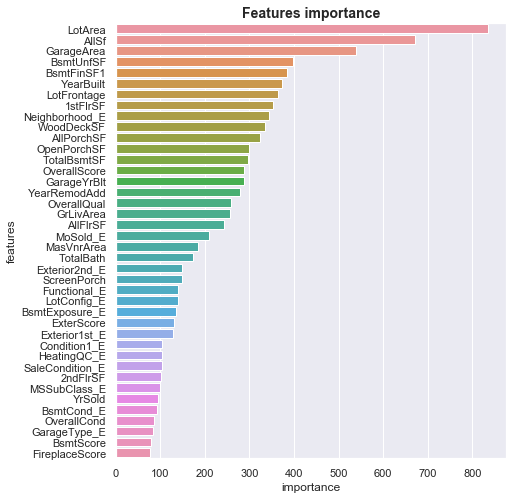

In [127]:
# features importance
importance_df = pd.DataFrame()
importance_df['features'] = X_train_lgbm.columns
importance_df['importance'] = reg_lgbm.feature_importances_
importance_df.sort_values('importance', ascending=False, inplace=True)
tmp_df = importance_df.iloc[:40, :]

plt.figure(figsize=(7, 0.2*len(tmp_df.index)))
ax = sns.barplot(
    data=tmp_df,
    x='importance',
    y='features',
)

ax.set_title('Features importance', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [128]:
# select features
to_drop_cols = importance_df.loc[importance_df['importance'] < 1e-3]['features'].tolist()
print('removes {}/{} features'.format(len(to_drop_cols), X_train_lgbm.shape[1]))

removes 81/155 features


In [129]:
# re-train
reg_lgbm = lgbm.LGBMRegressor(
    objective='root_mean_squared_error',
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.5,
    colsample_bylevel=0.5,
    reg_lambda=100,
    random_state=42
)

reg_lgbm.fit(
    X=X_train_lgbm.drop(columns=to_drop_cols),
    y=y_train_lgbm,
    eval_set=[(X_dev_lgbm.drop(columns=to_drop_cols), y_dev_lgbm)],
    eval_metric='rmse',
    early_stopping_rounds=100
)

[1]	valid_0's rmse: 0.382298
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.373131
[3]	valid_0's rmse: 0.364736
[4]	valid_0's rmse: 0.356726
[5]	valid_0's rmse: 0.348534
[6]	valid_0's rmse: 0.341252
[7]	valid_0's rmse: 0.333798
[8]	valid_0's rmse: 0.326982
[9]	valid_0's rmse: 0.320767
[10]	valid_0's rmse: 0.314648
[11]	valid_0's rmse: 0.308691
[12]	valid_0's rmse: 0.303341
[13]	valid_0's rmse: 0.298609
[14]	valid_0's rmse: 0.293236
[15]	valid_0's rmse: 0.288202
[16]	valid_0's rmse: 0.283207
[17]	valid_0's rmse: 0.278549
[18]	valid_0's rmse: 0.274055
[19]	valid_0's rmse: 0.270012
[20]	valid_0's rmse: 0.265999
[21]	valid_0's rmse: 0.262031
[22]	valid_0's rmse: 0.258317
[23]	valid_0's rmse: 0.254454
[24]	valid_0's rmse: 0.25107
[25]	valid_0's rmse: 0.247638
[26]	valid_0's rmse: 0.244564
[27]	valid_0's rmse: 0.24182
[28]	valid_0's rmse: 0.239054
[29]	valid_0's rmse: 0.236169
[30]	valid_0's rmse: 0.233535
[31]	valid_0's rmse: 0.230813
[32]	valid_0's rmse

[311]	valid_0's rmse: 0.135625
[312]	valid_0's rmse: 0.135529
[313]	valid_0's rmse: 0.135457
[314]	valid_0's rmse: 0.135391
[315]	valid_0's rmse: 0.135349
[316]	valid_0's rmse: 0.135344
[317]	valid_0's rmse: 0.135317
[318]	valid_0's rmse: 0.135253
[319]	valid_0's rmse: 0.135204
[320]	valid_0's rmse: 0.135142
[321]	valid_0's rmse: 0.135089
[322]	valid_0's rmse: 0.135035
[323]	valid_0's rmse: 0.134998
[324]	valid_0's rmse: 0.134933
[325]	valid_0's rmse: 0.134885
[326]	valid_0's rmse: 0.134835
[327]	valid_0's rmse: 0.134791
[328]	valid_0's rmse: 0.134717
[329]	valid_0's rmse: 0.134662
[330]	valid_0's rmse: 0.13463
[331]	valid_0's rmse: 0.134594
[332]	valid_0's rmse: 0.134554
[333]	valid_0's rmse: 0.13454
[334]	valid_0's rmse: 0.134456
[335]	valid_0's rmse: 0.134378
[336]	valid_0's rmse: 0.13431
[337]	valid_0's rmse: 0.134259
[338]	valid_0's rmse: 0.13418
[339]	valid_0's rmse: 0.134121
[340]	valid_0's rmse: 0.134086
[341]	valid_0's rmse: 0.13405
[342]	valid_0's rmse: 0.133994
[343]	valid_0

[651]	valid_0's rmse: 0.127397
[652]	valid_0's rmse: 0.127337
[653]	valid_0's rmse: 0.127327
[654]	valid_0's rmse: 0.127314
[655]	valid_0's rmse: 0.127327
[656]	valid_0's rmse: 0.127333
[657]	valid_0's rmse: 0.127338
[658]	valid_0's rmse: 0.127318
[659]	valid_0's rmse: 0.127289
[660]	valid_0's rmse: 0.127267
[661]	valid_0's rmse: 0.127265
[662]	valid_0's rmse: 0.12727
[663]	valid_0's rmse: 0.127233
[664]	valid_0's rmse: 0.127229
[665]	valid_0's rmse: 0.127242
[666]	valid_0's rmse: 0.127224
[667]	valid_0's rmse: 0.127185
[668]	valid_0's rmse: 0.127167
[669]	valid_0's rmse: 0.12714
[670]	valid_0's rmse: 0.127142
[671]	valid_0's rmse: 0.127146
[672]	valid_0's rmse: 0.127138
[673]	valid_0's rmse: 0.127101
[674]	valid_0's rmse: 0.127116
[675]	valid_0's rmse: 0.1271
[676]	valid_0's rmse: 0.127096
[677]	valid_0's rmse: 0.127084
[678]	valid_0's rmse: 0.127067
[679]	valid_0's rmse: 0.12707
[680]	valid_0's rmse: 0.127049
[681]	valid_0's rmse: 0.127025
[682]	valid_0's rmse: 0.127036
[683]	valid_0

[989]	valid_0's rmse: 0.12443
[990]	valid_0's rmse: 0.124405
[991]	valid_0's rmse: 0.124413
[992]	valid_0's rmse: 0.124427
[993]	valid_0's rmse: 0.124446
[994]	valid_0's rmse: 0.124433
[995]	valid_0's rmse: 0.124419
[996]	valid_0's rmse: 0.124406
[997]	valid_0's rmse: 0.124415
[998]	valid_0's rmse: 0.124401
[999]	valid_0's rmse: 0.12441
[1000]	valid_0's rmse: 0.124404
[1001]	valid_0's rmse: 0.124413
[1002]	valid_0's rmse: 0.124407
[1003]	valid_0's rmse: 0.124405
[1004]	valid_0's rmse: 0.124404
[1005]	valid_0's rmse: 0.124395
[1006]	valid_0's rmse: 0.12438
[1007]	valid_0's rmse: 0.124373
[1008]	valid_0's rmse: 0.124344
[1009]	valid_0's rmse: 0.124349
[1010]	valid_0's rmse: 0.124336
[1011]	valid_0's rmse: 0.124339
[1012]	valid_0's rmse: 0.124329
[1013]	valid_0's rmse: 0.124344
[1014]	valid_0's rmse: 0.124337
[1015]	valid_0's rmse: 0.124326
[1016]	valid_0's rmse: 0.1243
[1017]	valid_0's rmse: 0.12428
[1018]	valid_0's rmse: 0.124281
[1019]	valid_0's rmse: 0.124269
[1020]	valid_0's rmse: 0.

[1355]	valid_0's rmse: 0.123309
[1356]	valid_0's rmse: 0.123319
[1357]	valid_0's rmse: 0.12331
[1358]	valid_0's rmse: 0.123303
[1359]	valid_0's rmse: 0.123284
[1360]	valid_0's rmse: 0.123279
[1361]	valid_0's rmse: 0.123268
[1362]	valid_0's rmse: 0.123265
[1363]	valid_0's rmse: 0.123268
[1364]	valid_0's rmse: 0.123277
[1365]	valid_0's rmse: 0.123297
[1366]	valid_0's rmse: 0.123288
[1367]	valid_0's rmse: 0.12329
[1368]	valid_0's rmse: 0.123283
[1369]	valid_0's rmse: 0.123279
[1370]	valid_0's rmse: 0.123273
[1371]	valid_0's rmse: 0.123262
[1372]	valid_0's rmse: 0.123253
[1373]	valid_0's rmse: 0.123261
[1374]	valid_0's rmse: 0.123257
[1375]	valid_0's rmse: 0.123273
[1376]	valid_0's rmse: 0.123274
[1377]	valid_0's rmse: 0.123277
[1378]	valid_0's rmse: 0.123276
[1379]	valid_0's rmse: 0.123276
[1380]	valid_0's rmse: 0.123283
[1381]	valid_0's rmse: 0.123294
[1382]	valid_0's rmse: 0.123291
[1383]	valid_0's rmse: 0.123305
[1384]	valid_0's rmse: 0.123309
[1385]	valid_0's rmse: 0.123318
[1386]	val

[1656]	valid_0's rmse: 0.122813
[1657]	valid_0's rmse: 0.122794
[1658]	valid_0's rmse: 0.122788
[1659]	valid_0's rmse: 0.122789
[1660]	valid_0's rmse: 0.122795
[1661]	valid_0's rmse: 0.122791
[1662]	valid_0's rmse: 0.122788
[1663]	valid_0's rmse: 0.122781
[1664]	valid_0's rmse: 0.122781
[1665]	valid_0's rmse: 0.122788
[1666]	valid_0's rmse: 0.122777
[1667]	valid_0's rmse: 0.122776
[1668]	valid_0's rmse: 0.122781
[1669]	valid_0's rmse: 0.122775
[1670]	valid_0's rmse: 0.122778
[1671]	valid_0's rmse: 0.122782
[1672]	valid_0's rmse: 0.122789
[1673]	valid_0's rmse: 0.12279
[1674]	valid_0's rmse: 0.122795
[1675]	valid_0's rmse: 0.122798
[1676]	valid_0's rmse: 0.122795
[1677]	valid_0's rmse: 0.122804
[1678]	valid_0's rmse: 0.122805
[1679]	valid_0's rmse: 0.122809
[1680]	valid_0's rmse: 0.122817
[1681]	valid_0's rmse: 0.122823
[1682]	valid_0's rmse: 0.122818
[1683]	valid_0's rmse: 0.122819
[1684]	valid_0's rmse: 0.122817
[1685]	valid_0's rmse: 0.122818
[1686]	valid_0's rmse: 0.122815
[1687]	va

[1947]	valid_0's rmse: 0.122625
[1948]	valid_0's rmse: 0.122634
[1949]	valid_0's rmse: 0.122633
[1950]	valid_0's rmse: 0.122634
[1951]	valid_0's rmse: 0.122629
[1952]	valid_0's rmse: 0.122634
[1953]	valid_0's rmse: 0.122645
[1954]	valid_0's rmse: 0.122648
[1955]	valid_0's rmse: 0.122661
[1956]	valid_0's rmse: 0.122664
[1957]	valid_0's rmse: 0.122661
[1958]	valid_0's rmse: 0.122656
[1959]	valid_0's rmse: 0.122652
[1960]	valid_0's rmse: 0.122665
[1961]	valid_0's rmse: 0.122684
[1962]	valid_0's rmse: 0.122694
[1963]	valid_0's rmse: 0.122696
[1964]	valid_0's rmse: 0.12269
[1965]	valid_0's rmse: 0.122673
[1966]	valid_0's rmse: 0.122668
[1967]	valid_0's rmse: 0.122669
[1968]	valid_0's rmse: 0.122663
[1969]	valid_0's rmse: 0.122656
[1970]	valid_0's rmse: 0.122654
[1971]	valid_0's rmse: 0.122647
[1972]	valid_0's rmse: 0.122638
[1973]	valid_0's rmse: 0.122655
[1974]	valid_0's rmse: 0.122658
[1975]	valid_0's rmse: 0.122657
[1976]	valid_0's rmse: 0.122662
[1977]	valid_0's rmse: 0.122672
[1978]	va

LGBMRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05,
              max_depth=3, n_estimators=5000,
              objective='root_mean_squared_error', random_state=42,
              reg_lambda=100, subsample=0.8)

In [130]:
%%time
# re-evaluate
print('on train:')
rmse_cv(reg_lgbm, X_train_lgbm.drop(columns=to_drop_cols), y_train_lgbm)

print('on dev:')
rmse_cv(reg_lgbm, X_dev_lgbm.drop(columns=to_drop_cols), y_dev_lgbm)

on train:
rmse_cv: 0.11043857157490995
on dev:
rmse_cv: 0.131842817560914
Wall time: 43.5 s


In [131]:
# re-predict
y_pred_dev_lgbm = reg_lgbm.predict(X_dev_lgbm.drop(columns=to_drop_cols))
y_pred_lgbm = reg_lgbm.predict(X_test_lgbm.drop(columns=to_drop_cols))

# Neural network

## Split data

In [132]:
# split data
X_test_nn = X_test.copy()
X_train_nn, X_dev_nn, y_train_nn, y_dev_nn = split_data(X_train, y_train)

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)


## Preprocess

In [133]:
# preprocess num_features
X_train_num = normalize_num_features(X_train_nn[num_features], X_train_nn[num_features], method='standard')
X_dev_num = normalize_num_features(X_train_nn[num_features], X_dev_nn[num_features], method='standard')
X_test_num = normalize_num_features(X_train_nn[num_features], X_test_nn[num_features], method='standard')

print('X_train_num shape: {}'.format(X_train_num.shape))
print('X_dev_num shape: {}'.format(X_dev_num.shape))
print('X_test_num shape: {}'.format(X_test_num.shape))

X_train_num shape: (1083, 155)
X_dev_num shape: (361, 155)
X_test_num shape: (1459, 155)


In [134]:
# preprocess cat_features
X_train_cat = encode_cat_features(X_train[cat_features], X_train_nn[cat_features], method='onehot')
X_dev_cat = encode_cat_features(X_train[cat_features], X_dev_nn[cat_features], method='onehot')
X_test_cat = encode_cat_features(X_train[cat_features], X_test_nn[cat_features], method='onehot')

print('X_train_cat shape: {}'.format(X_train_cat.shape))
print('X_dev_cat shape: {}'.format(X_dev_cat.shape))
print('X_test_cat shape: {}'.format(X_test_cat.shape))

X_train_cat shape: (1083, 0)
X_dev_cat shape: (361, 0)
X_test_cat shape: (1459, 0)


In [135]:
# concatenate
X_train_nn = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_dev_nn = pd.concat([X_dev_num.reset_index(drop=True), X_dev_cat.reset_index(drop=True)], axis=1)
X_test_nn = pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

print('X_train shape: {}, y_train shape: {}'.format(X_train_nn.shape, y_train_nn.shape))
print('X_dev shape: {}, y_dev shape: {}'.format(X_dev_nn.shape, y_dev_nn.shape))
print('X_test shape: {}'.format(X_test_nn.shape))

X_train shape: (1083, 155), y_train shape: (1083,)
X_dev shape: (361, 155), y_dev shape: (361,)
X_test shape: (1459, 155)


## Neural network

In [136]:
# model
input_dim = X_train_nn.shape[1]

def model(input_dim):    
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

nn = model(input_dim)
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               39936     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                6

In [137]:
# train model
history = nn.fit(
    X_train_nn, y_train_nn,
    batch_size=64, epochs=2000,
    validation_data=(X_dev_nn, y_dev_nn),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=False),
    ]
)

Epoch 1/2000
17/17 [==============================] - 1s 34ms/step - loss: 145.2655 - root_mean_squared_error: 12.0526 - val_loss: 150.5682 - val_root_mean_squared_error: 12.2706
Epoch 2/2000
17/17 [==============================] - 0s 9ms/step - loss: 142.5102 - root_mean_squared_error: 11.9378 - val_loss: 146.7655 - val_root_mean_squared_error: 12.1147
Epoch 3/2000
17/17 [==============================] - 0s 9ms/step - loss: 140.1908 - root_mean_squared_error: 11.8402 - val_loss: 143.9763 - val_root_mean_squared_error: 11.9990
Epoch 4/2000
17/17 [==============================] - 0s 9ms/step - loss: 137.7641 - root_mean_squared_error: 11.7373 - val_loss: 140.1144 - val_root_mean_squared_error: 11.8370
Epoch 5/2000
17/17 [==============================] - 0s 9ms/step - loss: 135.1015 - root_mean_squared_error: 11.6233 - val_loss: 137.9488 - val_root_mean_squared_error: 11.7452
Epoch 6/2000
17/17 [==============================] - 0s 9ms/step - loss: 132.2886 - root_mean_squared_error:

17/17 [==============================] - ETA: 0s - loss: 2.4104 - root_mean_squared_error: 1.552 - 0s 10ms/step - loss: 2.3725 - root_mean_squared_error: 1.5403 - val_loss: 2.4827 - val_root_mean_squared_error: 1.5756
Epoch 48/2000
17/17 [==============================] - 0s 8ms/step - loss: 1.9441 - root_mean_squared_error: 1.3943 - val_loss: 2.0362 - val_root_mean_squared_error: 1.4269
Epoch 49/2000
17/17 [==============================] - 0s 8ms/step - loss: 1.5885 - root_mean_squared_error: 1.2604 - val_loss: 1.6987 - val_root_mean_squared_error: 1.3033
Epoch 50/2000
17/17 [==============================] - 0s 8ms/step - loss: 1.2887 - root_mean_squared_error: 1.1352 - val_loss: 1.3359 - val_root_mean_squared_error: 1.1558
Epoch 51/2000
17/17 [==============================] - 0s 8ms/step - loss: 1.0382 - root_mean_squared_error: 1.0189 - val_loss: 1.1240 - val_root_mean_squared_error: 1.0602
Epoch 52/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.8395 - root_m

Epoch 94/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1358
Epoch 95/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0328 - root_mean_squared_error: 0.1810 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 96/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0314 - root_mean_squared_error: 0.1772 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 97/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1323
Epoch 98/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 99/2000
17/17 [==============================] - 0s 7ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755 - val_loss: 0.0192 

17/17 [==============================] - 0s 8ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 142/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 143/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 144/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1308
Epoch 145/2000
17/17 [==============================] - 0s 11ms/step - loss: 0.0244 - root_mean_squared_error: 0.1561 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 146/2000
17/17 [==============================] - 0s 12ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.0149 - val_

Epoch 188/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 189/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 190/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 191/2000
17/17 [==============================] - 0s 11ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 192/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 193/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_l

Epoch 235/2000
17/17 [==============================] - 0s 15ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1186
Epoch 236/2000
17/17 [==============================] - 0s 14ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 237/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 238/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 239/2000
17/17 [==============================] - 0s 10ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 240/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss

17/17 [==============================] - 0s 7ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 283/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 284/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 285/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 286/2000
17/17 [==============================] - 0s 7ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 287/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0129 - val_roo

17/17 [==============================] - 0s 12ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 330/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 331/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 332/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 333/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 334/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0132 - val_ro

17/17 [==============================] - 0s 9ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 377/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 378/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 379/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 380/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 381/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.0139 - root_mean_squared_error: 0.1179 - val_loss: 0.0126 - val_roo

In [138]:
# evaluate
nn.evaluate(X_dev_nn, y_dev_nn)

12/12 [==============================] - 0s 1ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125


[0.01266020629554987, 0.1125175803899765]

In [139]:
def get_training_metrics(history):
    if not isinstance(history, pd.core.frame.DataFrame):
        history = history.history

    rmse = history['root_mean_squared_error']
    val_rmse = history['val_root_mean_squared_error']

    loss = history['loss']
    val_loss = history['val_loss']

    return rmse, val_rmse, loss, val_loss

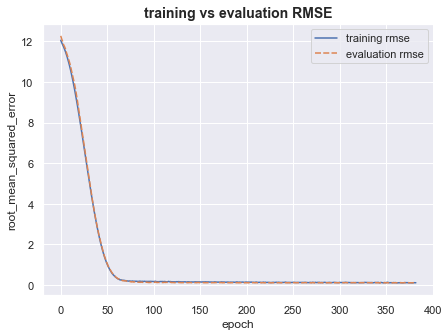

In [140]:
def plot_train_eval(history):
    rmse, val_rmse, loss, val_loss = get_training_metrics(history)

    acc_plot = pd.DataFrame({'training rmse': rmse, 'evaluation rmse': val_rmse})
    plt.figure(figsize=(7, 5))
    acc_plot = sns.lineplot(data=acc_plot)
    acc_plot.set_title('training vs evaluation RMSE', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    acc_plot.set_xlabel('epoch')
    acc_plot.set_ylabel('root_mean_squared_error')
    plt.show()

    # print('')

    # loss_plot = pd.DataFrame({'training loss': loss, 'evaluation loss': val_loss})
    # plt.figure(figsize=(7, 5))
    # loss_plot = sns.lineplot(data=loss_plot)
    # loss_plot.set_title('training vs evaluation loss')
    # loss_plot.set_xlabel('epoch')
    # loss_plot.set_ylabel('loss')
    # plt.show()

plot_train_eval(history)

In [141]:
# predict
y_pred_dev_nn = nn.predict(X_dev_nn)[:, 0]
y_pred_nn = nn.predict(X_test_nn)[:, 0]

# Stacking: average

In [142]:
# average 5 models
y_pred_dev = 0.2*y_pred_dev_ridge + 0.2*y_pred_dev_lasso + 0.2*y_pred_dev_xgb + 0.1*y_pred_dev_lgbm + 0.3*y_pred_dev_nn
y_pred = np.exp(0.2*y_pred_ridge + 0.2*y_pred_lasso + 0.2*y_pred_xgb + 0.1*y_pred_lgbm + 0.3*y_pred_nn)

print('rmse: {}'.format(np.sqrt(mean_squared_error(y_dev_linear, y_pred_dev))))

rmse: 0.10794990611258808


In [143]:
# aggregate preditions (best: 0.2, 0.2, 0.2, 0.1, 0.3)
pred_df = pd.DataFrame({
    'Id': test_df['Id'].values,
    'SalePrice': y_pred
})

pred_df.head()

,Id,SalePrice
0,1461,120384.918291
1,1462,161067.770186
2,1463,186428.122545
3,1464,193206.241127
4,1465,193326.705077


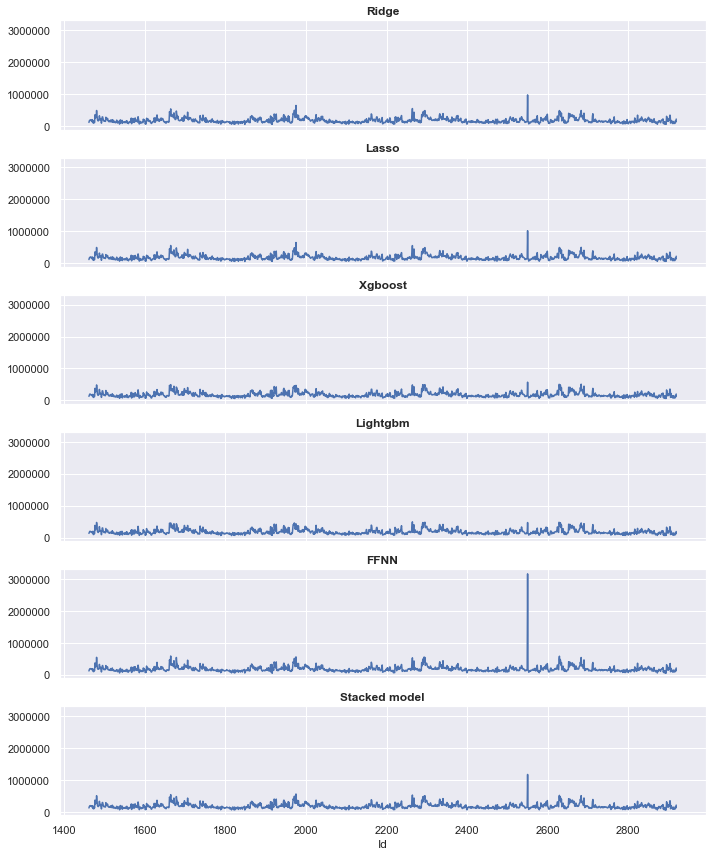

In [144]:
# plot predicted values
preds = [np.exp(y_pred_ridge), np.exp(y_pred_lasso), np.exp(y_pred_xgb), np.exp(y_pred_lgbm), np.exp(y_pred_nn), y_pred]
fig, axes = plt.subplots(
    nrows=6, ncols=1,
    sharey=True, sharex=True,
    figsize=(10, 2*len(preds))
)

for pred, ax, in zip(preds, axes.flatten()):
    sns.lineplot(
        x=test_df['Id'],
        y=pred,
        ax=ax
    )

axes[0].set_title('Ridge', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Lasso', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axes[2].set_title('Xgboost', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axes[3].set_title('Lightgbm', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axes[4].set_title('FFNN', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axes[5].set_title('Stacked model', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

In [146]:
pred_df.to_csv('submission/submission.csv', index=False)

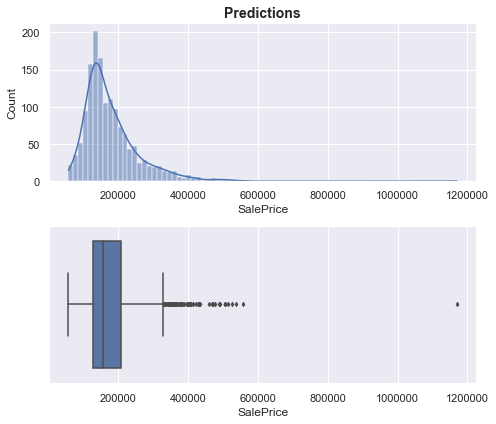

In [147]:
# plot predictions
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    # sharex=True,
    figsize=(7, 3*2))

sns.histplot(
    data=pred_df,
    x='SalePrice',
    kde=True,
    ax=axes[0]
)
sns.boxplot(
    data=pred_df,
    x='SalePrice',
    fliersize=3,
    ax=axes[1]
)

axes[0].set_title('Predictions', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.tight_layout()
plt.show()

In [148]:
pred_df.sort_values('SalePrice', ascending=False)

,Id,SalePrice
1089,2550,1.169440e+06
514,1975,5.579766e+05
203,1664,5.378097e+05
803,2264,5.248607e+05
1168,2629,5.144995e+05
...,...,...
1433,2894,5.827013e+04
387,1848,5.803026e+04
455,1916,5.758659e+04
1431,2892,5.698951e+04


In [149]:
# replace Id 2550's SalePrice
print('0.75 quantile: {}'.format(pred_df['SalePrice'].quantile(0.75)))

idx = pred_df.loc[pred_df['Id'] == 2550].index
pred_df.loc[idx, 'SalePrice'] = pred_df['SalePrice'].quantile(0.75)

0.75 quantile: 208201.10221168073


In [150]:
pred_df.loc[pred_df['Id'] == 2550]

,Id,SalePrice
1089,2550,208201.102212


In [152]:
pred_df.to_csv('submission/submission_rev.csv', index=False)